In [ ]:
import os

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Nitorch

## Reading data

In [ ]:
import numpy as np
import nibabel as nib
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import nibabel
import os

In [ ]:
def load_nifti(file_path, dtype=np.float32, incl_header=False, z_factor=None, mask=None):
    """
    Loads a volumetric image in nifti format (extensions .nii, .nii.gz etc.)
    as a 3D numpy.ndarray.

    Args:
        file_path: absolute path to the nifti file

        dtype(optional): datatype of the loaded numpy.ndarray

        incl_header(bool, optional): If True, the nifTI object of the
        image is also returned.

        z_factor(float or sequence, optional): The zoom factor along the
        axes. If a float, zoom is the same for each axis. If a sequence,
        zoom should contain one value for each axis.

        mask(ndarray, optional): A mask with the same shape as the
        original image. If provided then the mask is element-wise
        multiplied with the image ndarray

    Returns:
        3D numpy.ndarray with axis order (saggital x coronal x axial)
    """

    img = nib.load(file_path)
    struct_arr = img.get_data().astype(dtype)

    # replace infinite values with 0
    if np.inf in struct_arr:
        struct_arr[struct_arr == np.inf] = 0.

    # replace NaN values with 0
    if np.isnan(struct_arr).any() == True:
        struct_arr[np.isnan(struct_arr)] = 0.

    if mask is not None:
        struct_arr *= mask

    if z_factor is not None:
        struct_arr = zoom(struct_arr, z_factor)

    if incl_header:
        return struct_arr, img
    else:
        return struct_arr

In [ ]:
def show_brain(img, cut_coords=None,
               figsize=(10,5), cmap="nipy_spectral",
               draw_cross = True,
               return_fig = False
               ):
    """Displays 2D cross-sections of a 3D image along all 3 axis
    Arg:
        img: can be (1) 3-dimensional numpy.ndarray
                    (2) nibabel.Nifti1Image object
                    (3) path to the image file stored in nifTI format
        cut_coords (optional): The voxel coordinates
        of the axes where the cross-section cuts will be performed.
        Should be a 3-tuple: (x, y, z). Default is the center = img_shape/2

        figsize (optional): matplotlib figsize. Default is (10,5)
        cmap (optional): matplotlib colormap to be used

        draw_cross (optional): Draws horizontal and vertical lines which
        show where the cross-sections have been performed. D

        example:
            >>> show_brain(img, figsize=(7, 3), draw_cross=False)
            >>> plt.show()
        """

    if(isinstance(img, str) and os.path.isfile(img)):
        img_arr = load_nifti(img)
    elif(isinstance(img, nibabel.Nifti1Image)):
        img_arr = img.get_data()

    elif(isinstance(img, np.ndarray)):
        assert img.ndim == 3, "The numpy.ndarray must be 3-dimensional with shape (H x W x Z)"
        img_arr = img
    else:
        raise TypeError("Invalid type provided for 'img'- {}. \
Either provide a 3-dimensional numpy.ndarray of a MRI image or path to \
the image file stored as a nifTI format.".format(type(img)))

    # print(img_arr.shape)
    # img_arr = np.moveaxis(img_arr, 0, 1)
    # print(img_arr.shape)

    x_len, y_len, z_len = img_arr.shape
    # if cut_coordinates is not specified set it to the center of the image
    if(cut_coords == None):
        cut_coords = (x_len//2, y_len//2, z_len//2)

    f, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    ax[0].set_title("Saggital cross-section at x={}".format(cut_coords[0]))
    ax[0].imshow(
         np.rot90(img_arr[cut_coords[0],:,:]), cmap=cmap, aspect="equal")
    #draw cross
    if(draw_cross):
        ax[0].axvline(x=cut_coords[1], color='k', linewidth=1)
        ax[0].axhline(y=cut_coords[2], color='k', linewidth=1)

    ax[1].set_title("Coronal cross-section at y={}".format(cut_coords[1]))
    ax[1].imshow(
        np.rot90(img_arr[:,cut_coords[1],:]), cmap=cmap, aspect="equal")
    ax[1].text(0.05, 0.95,'L',
        horizontalalignment='left', verticalalignment='top',
        transform=ax[1].transAxes
        , bbox=dict(facecolor='white')
        )
    ax[1].text(0.95, 0.95,'R',
        horizontalalignment='right', verticalalignment='top'
        , transform=ax[1].transAxes
        , bbox=dict(facecolor='white')
        )
    #draw cross
    if(draw_cross):
        ax[1].axvline(x=cut_coords[0], color='k', linewidth=1)
        ax[1].axhline(y=cut_coords[2], color='k', linewidth=1)

    ax[2].set_title("Axial cross-section at z={}".format(cut_coords[2]))
    ax[2].imshow(
        np.rot90(img_arr[:,:,cut_coords[2]]), cmap=cmap, aspect="equal"
        )
    ax[2].text(0.05, 0.95,'L'
        , horizontalalignment='left', verticalalignment='top'
        , transform=ax[2].transAxes
        , bbox=dict(facecolor='white')
        )
    ax[2].text(0.95, 0.95,'R',
        horizontalalignment='right', verticalalignment='top'
        , transform=ax[2].transAxes
        , bbox=dict(facecolor='white')
        )
    #draw cross
    if(draw_cross):
        ax[2].axvline(x=cut_coords[0], color='k', linewidth=1)
        ax[2].axhline(y=cut_coords[1], color='k', linewidth=1)

    plt.tight_layout()
    if return_fig:
        return f

## Transforms

In [ ]:
import numbers
import torch
from scipy.ndimage.interpolation import rotate

In [ ]:
def normalize_float(x, min=-1):
    """
    Function that performs min-max normalization on a `numpy.ndarray`
    matrix.
    """
    if min == -1:
        norm = (2 * (x - np.min(x)) / (np.max(x) - np.min(x))) - 1
    elif min == 0:
        if np.max(x) == 0 and np.min(x) == 0:
            norm = x
        else:
            norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    return norm

In [ ]:
def normalize_float_torch(x, min=-1):
    '''
    Function that performs min-max normalization on a Pytorch tensor
    matrix. Can also deal with Pytorch dictionaries where the data
    matrix key is 'image'.
    '''
    import torch
    if min == -1:
        norm = (2 * (x - torch.min(x)) / (torch.max(x) - torch.min(x))) - 1
    elif min == 0:
        if torch.max(x) == 0 and torch.min(x) == 0:
            norm = x
        else:
            norm = (x - torch.min(x)) / (torch.max(x) - torch.min(x))
    return norm

In [ ]:
def normalization_factors(data, train_idx, shape, mode="slice"):
    """
    Shape should be of length 3.
    mode : either "slice" or "voxel" - defines the granularity of the
    normalization. Voxelwise normalization does not work well with only
    linear registered data.
    """
    print("Computing the normalization factors of the training data..")
    if mode == "slice":
        axis = (0, 1, 2, 3)
    elif mode == "voxel":
        axis = 0
    else:
        raise NotImplementedError("Normalization mode unknown.")
    samples = np.zeros(
        [len(train_idx), 1, shape[0], shape[1], shape[2]], dtype=np.float32
    )
    for c, value in enumerate(train_idx):
        samples[c] = data[value]["image"].numpy()
    mean = np.mean(samples, axis=axis)
    std = np.std(samples, axis=axis)
    return np.squeeze(mean), np.squeeze(std)

In [ ]:
class CenterCrop(object):
    """Crops the given 3D ndarray Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w, d), a cube crop (size, size, size) is
            made.
    """
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size), int(size))
        else:
            self.size = np.asarray(size)
        assert len(self.size) == 3, "The `size` must be a tuple of length 3 but is \
length {}".format(len(self.size))

    def __call__(self, img):
        """
        Args:
            3D ndarray Image : Image to be cropped.
        Returns:
            3D ndarray Image: Cropped image.
        """
        # if the 4th dimension of the image is the batch then ignore that dim
        if len(img.shape) == 4:
            img_size = img.shape[1:]
        elif len(img.shape) == 3:
            img_size = img.shape
        else:
            raise ValueError("The size of the image can be either 3 dimension or 4\
dimension with one dimension as the batch size")

        # crop only if the size of the image is bigger than the size to be cropped to.
        if all(img_size >= self.size):
            slice_start = (img_size - self.size)//2
            slice_end = self.size + slice_start
            cropped = img[slice_start[0]:slice_end[0],
                          slice_start[1]:slice_end[1],
                          slice_start[2]:slice_end[2]
                         ]
            if len(img.shape) == 4:
                cropped = np.expand_dims(cropped, 0)
        else:
            cropped = img

        return cropped

    def __repr__(self):
        return self.__class__.__name__ + '(size={0})'.format(self.size)

In [ ]:
class Normalize(object):
    """
    Normalize tensor with first and second moments.
    By default will only normalize on non-zero voxels. Set
    masked = False if this is undesired.
    """

    def __init__(self, mean, std=1, masked=True, eps=1e-10):
        self.mean = mean
        self.std = std
        self.masked = masked
        # set epsilon only if using std scaling
        self.eps = eps if np.all(std) != 1 else 0

    def __call__(self, image):
        if self.masked:
            image = self.zero_masked_transform(image)
        else:
            image = self.apply_transform(image)
        return image

    def denormalize(self, image):
        image = image * (self.std + self.eps) + self.mean
        return image

    def apply_transform(self, image):
        return (image - self.mean) / (self.std + self.eps)

    def zero_masked_transform(self, image):
        """ Only apply transform where input is not zero. """
        img_mask = image == 0
        # do transform
        image = self.apply_transform(image)
        image[img_mask] = 0.
        return image

In [ ]:
class IntensityRescale:
    """
    Rescale image itensities between 0 and 1 for a single image.
    Arguments:
        masked: applies normalization only on non-zero voxels. Default
            is True.
        on_gpu: speed up computation by using GPU. Requires torch.Tensor
             instead of np.array. Default is False.
    """

    def __init__(self, masked=True, on_gpu=False):
        self.masked = masked
        self.on_gpu = on_gpu

    def __call__(self, image):
        if self.masked:
            image = self.zero_masked_transform(image)
        else:
            image = self.apply_transform(image)

        return image

    def apply_transform(self, image):
        if self.on_gpu:
            return normalize_float_torch(image, min=0)
        else:
            return normalize_float(image, min=0)

    def zero_masked_transform(self, image):
        """ Only apply transform where input is not zero. """
        img_mask = image == 0
        # do transform
        image = self.apply_transform(image)
        image[img_mask] = 0.
        return image

## Data Augmentation

In [ ]:
class ToTensor(object):
    """
    Convert ndarrays to Tensors.
    Expands channel axis
    # numpy image: H x W x Z
    # torch image: C x H x W x Z
    """

    def __call__(self, image):
        image = torch.from_numpy(image).unsqueeze(0)
        image = image.float()
        return image

In [ ]:
class Flip:
    """
    Flip the input along a given axis.
    Arguments:
        axis: axis to flip over. Default is 0
        prob: probability to flip the image. Executes always when set to
             1. Default is 0.5
    """
    def __init__(self, axis=0, prob=0.5):
        self.axis = axis
        self.prob = prob

    def __call__(self, image):
        rand = np.random.uniform()
        if rand <= self.prob:
            augmented = np.flip(image, axis=self.axis).copy()
        else:
            augmented = image
        return augmented

In [ ]:
class SagittalFlip(Flip):
    """
    Flip image along the sagittal axis (x-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, prob=0.5):
        super().__init__(axis=0, prob=prob)

    def __call__(self, image):
        assert(len(image.shape) == 3)
        return super().__call__(image)

In [ ]:
class CoronalFlip(Flip):
    """
    Flip image along the coronal axis (y-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, prob=0.5):
        super().__init__(axis=1, prob=prob)

    def __call__(self, image):
        assert(len(image.shape) == 3)
        return super().__call__(image)

In [ ]:
class AxialFlip(Flip):
    """
    Flip image along the axial axis (z-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, prob=0.5):
        super().__init__(axis=2, prob=prob)

    def __call__(self, image):
        assert(len(image.shape) == 3)
        return super().__call__(image)

In [ ]:
class Rotate:
    """
    Rotate the input along a given axis.
    Arguments:
        axis: axis to rotate. Default is 0
        deg: min and max rotation angles in degrees. Randomly rotates
            within that range. Can be scalar, list or tuple. In case of
            scalar it rotates between -abs(deg) and abs(deg). Default is
            (-3, 3).
    """
    def __init__(self, axis=0, deg=(-3, 3)):
        if axis == 0:
            self.axes = (1, 0)
        elif axis == 1:
            self.axes = (2, 1)
        elif axis == 2:
            self.axes = (0, 2)

        if isinstance(deg, tuple) or isinstance(deg, list):
            assert(len(deg) == 2)
            self.min_rot = np.min(deg)
            self.max_rot = np.max(deg)
        else:
            self.min_rot = -int(abs(deg))
            self.max_rot = int(abs(deg))

    def __call__(self, image):
        rand = np.random.randint(self.min_rot, self.max_rot + 1)
        augmented = rotate(
            image,
            angle=rand,
            axes=self.axes,
            reshape=False
            ).copy()
        return augmented

In [ ]:
class SagittalRotate(Rotate):
    """
    Rotate image's sagittal axis (x-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, deg=(-3, 3)):
        super().__init__(axis=0, deg=deg)

In [ ]:
class CoronalRotate(Rotate):
    """
    Rotate image's coronal axis (y-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, deg=(-3, 3)):
        super().__init__(axis=1, deg=deg)

In [ ]:
class AxialRotate(Rotate):
    """
    Rotate image's axial axis (z-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, deg=(-3, 3)):
        super().__init__(axis=2, deg=deg)

In [ ]:
class Translate:
    """
    Translate the input along a given axis.
    Arguments:
        axis: axis to rotate. Default is 0
        dist: min and max translation distance in pixels. Randomly
            translates within that range. Can be scalar, list or tuple.
            In case of scalar it translates between -abs(dist) and
            abs(dist). Default is (-3, 3).
    """
    def __init__(self, axis=0, dist=(-3, 3)):
        self.axis = axis

        if isinstance(dist, tuple) or isinstance(dist, list):
            assert(len(dist) == 2)
            self.min_trans = np.min(dist)
            self.max_trans = np.max(dist)
        else:
            self.min_trans = -int(abs(dist))
            self.max_trans = int(abs(dist))

    def __call__(self, image):
        rand = np.random.randint(self.min_trans, self.max_trans + 1)
        augmented = np.zeros_like(image)
        if self.axis == 0:
            if rand < 0:
                augmented[-rand:, :] = image[:rand, :]
            elif rand > 0:
                augmented[:-rand, :] = image[rand:, :]
            else:
                augmented = image
        elif self.axis == 1:
            if rand < 0:
                augmented[:,-rand:, :] = image[:,:rand, :]
            elif rand > 0:
                augmented[:,:-rand, :] = image[:,rand:, :]
            else:
                augmented = image
        elif self.axis == 2:
            if rand < 0:
                augmented[:,:,-rand:] = image[:,:,:rand]
            elif rand > 0:
                augmented[:,:,:-rand] = image[:,:,rand:]
            else:
                augmented = image
        return augmented

In [ ]:
class SagittalTranslate(Translate):
    """
    Translate image along the sagittal axis (x-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, dist=(-3, 3)):
        super().__init__(axis=0, dist=dist)

In [ ]:
class CoronalTranslate(Translate):
    """
    Translate image along the coronal axis (y-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, dist=(-3, 3)):
        super().__init__(axis=1, dist=dist)

In [ ]:
class AxialTranslate(Translate):
    """
    Translate image along the axial axis (z-axis).
    Expects input shape (X, Y, Z).
    """
    def __init__(self, dist=(-3, 3)):
        super().__init__(axis=2, dist=dist)

## Inferences

In [ ]:
import numpy
import torch
from torch import nn

In [ ]:
def predict(
    outputs,
    labels,
    all_preds,
    all_labels,
    prediction_type,
    criterion,
    **kwargs
    ):
    """ Predict according to loss and prediction type."""
    if prediction_type == "binary":
        if isinstance(criterion, nn.BCEWithLogitsLoss):
            all_preds, all_labels = bce_with_logits_inference(
                outputs,
                labels,
                all_preds,
                all_labels,
                **kwargs
            )
        elif isinstance(criterion, nn.BCELoss):
            all_preds, all_labels = bce_inference(
                outputs,
                labels,
                all_preds,
                all_labels,
                **kwargs
            )
    elif prediction_type == "classification":
        all_preds, all_labels = crossentropy_inference(
                outputs,
                labels,
                all_preds,
                all_labels
        )
    elif prediction_type == "regression":
        # TODO: test different loss functions
        all_preds, all_labels = regression_inference(
                outputs,
                labels,
                all_preds,
                all_labels
        )
    elif prediction_type == "reconstruction":
        # TODO: test different loss functions
        all_preds, all_labels = regression_inference(
                outputs,
                labels,
                all_preds,
                all_labels
        )
    elif prediction_type == "variational":
        # TODO: test different loss functions
        all_preds, all_labels = variational_inference(
                outputs,
                labels,
                all_preds,
                all_labels
        )
    else:
        raise NotImplementedError

    return all_preds, all_labels

In [ ]:
def bce_with_logits_inference(
    outputs,
    labels,
    all_preds,
    all_labels,
    **kwargs
    ):
    sigmoid = torch.sigmoid(outputs)
    if kwargs["class_threshold"]:
        class_threshold = kwargs["class_threshold"]
    else:
        class_threshold = 0.5
    print
    predicted = sigmoid.data >= class_threshold
    for pred, label in zip(predicted, labels):
        all_preds.append(pred.cpu().item())
        all_labels.append(int(label.cpu().item()))
    return all_preds, all_labels

In [ ]:
def bce_inference(
    outputs,
    labels,
    all_preds,
    all_labels,
    **kwargs
    ):
    if kwargs["class_threshold"]:
        class_threshold = kwargs["class_threshold"]
    else:
        class_threshold = 0.5
    predicted = outputs.data >= class_threshold
    for pred, label in zip(predicted, labels):
        all_preds.append(pred.cpu().item())
        all_labels.append(label.cpu().item())
    return all_preds, all_labels

In [ ]:
def crossentropy_inference(
    outputs,
    labels,
    all_preds,
    all_labels,
    **kwargs
    ):
    _, predicted = torch.max(outputs.data, 1)
    for pred, label in zip(predicted, labels):
        all_preds.append(pred.cpu().item())
        all_labels.append(label.cpu().item())
    return all_preds, all_labels

In [ ]:
def regression_inference(
    outputs,
    labels,
    all_preds,
    all_labels
    ):
    # Multi-head case
    # network returns a tuple of outputs
    if isinstance(outputs, (list,tuple)):
        predicted = [output.data for output in outputs]
        for head in range(len(predicted)):
            for j in range(len(predicted[head])):
                try:
                    all_preds[head].append(predicted[head][j].cpu().numpy()[0])
                    all_labels[head].append(labels[head][j].cpu().numpy()[0])
                except IndexError:
                    # create inner lists if needed
                    all_preds.append([predicted[head][j].cpu().numpy()[0]])
                    all_labels.append([labels[head][j].cpu().numpy()[0]])
        return all_preds, all_labels
    # Single-head case
    else:
        predicted = outputs[0].data
        # TODO: replace for loop with something faster
        for j in range(len(predicted)):
            try:
                all_preds.append(predicted[j].cpu().numpy().item())
                all_labels.append(labels[j].cpu().numpy().item())
            except:
                all_preds.append(predicted[j].cpu().numpy()[0])
                all_labels.append(labels[j].cpu().numpy()[0])
        return all_preds, all_labels

In [ ]:
def variational_inference(
    outputs,
    labels,
    all_preds,
    all_labels
    ):
    """ Inference for variational autoencoders. """
    # VAE outputs reconstruction, mu and std
    # select reconstruction only
    outputs = outputs[0]
    predicted = outputs.data
    # TODO: replace for loop with something faster
    for pred, label in zip(predicted, labels):
        all_preds.append(pred.cpu().item())
        all_labels.append(label.cpu().item())
    return all_preds, all_labels

## Utils

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
def dataset_length(data_loader):
    """
    Return the full length of the dataset from the DataLoader alone.
    Calling len(data_loader) only shows the number of mini-batches.
    Requires data to be located at
    """
    sample = next(iter(data_loader))

    if isinstance(sample, dict):
        try:
            if isinstance(sample["label"], torch.Tensor):
                batch_size = sample["label"].shape[0]
            else:
                # in case of sequence of inputs use first input
                batch_size = sample["label"][0].shape[0]
        except:
            KeyError("Expects key to be 'label'.")
    else:
        if isinstance(sample[1], torch.Tensor):
            batch_size = sample[1].shape[0]
        else:
            # in case of sequence of inputs use first input
            batch_size = sample[1][0].shape[0]
    return len(data_loader) * batch_size

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:
def is_bad_grad(grad_output):
    grad_output = grad_output.data
    return grad_output.ne(grad_output).any() or grad_output.gt(1e6).any()

## Models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class _CAE_3D(nn.Module):
    '''
    Parent Convolutional Autoencoder class for 3D images.
    All other Convolutional Autoencoder classes must inherit from this class.
    '''
    def __init__(self, conv_channels):
        super().__init__()
        # check if there are multiple convolution layers within a layer of the network or not
        self.is_nested_conv = ([isinstance(each_c, (list, tuple)) for each_c in conv_channels])
        if(any(self.is_nested_conv) and not all(self.is_nested_conv)):
             raise TypeError(" `conv_channels` can't be a mixture of both lists and ints.")
        self.is_nested_conv = any(self.is_nested_conv)

        self.layers = len(conv_channels)
        self.conv_channels = self._format_channels(conv_channels, self.is_nested_conv)
        self.valid_activations = {'ELU': nn.ELU, 'HARDSHRINK': nn.Hardshrink, 'HARDTANH': nn.Hardtanh,
 'LEAKYRELU':nn.LeakyReLU, 'LOGSIGMOID': nn.LogSigmoid, 'PRELU':nn.PReLU, 'RELU':nn.ReLU, 'RELU6': nn.ReLU6,
 'RRELU': nn.RReLU, 'SELU': nn.SELU, 'SIGMOID': nn.Sigmoid, 'SOFTPLUS': nn.Softplus,
 'SOFTSHRINK': nn.Softshrink, 'TANH': nn.Tanh, 'TANHSHRINK': nn.Tanhshrink, 'THRESHOLD': nn.Threshold}

    def _format_channels(self, conv_channels, is_nested_conv = False):
        channels = []
        if(is_nested_conv):
            for i in range(len(conv_channels)):
                    inner_channels = []
                    for j in range(len(conv_channels[i])):
                        if (i == 0) and (j == 0):
                            inner_channels.append([1, conv_channels[i][j]])
                        elif (j == 0) :
                            inner_channels.append([conv_channels[i-1][-1], conv_channels[i][j]])
                        else:
                            inner_channels.append([conv_channels[i][j-1], conv_channels[i][j]])
                    channels.append(inner_channels)
        else:
            for i in range(len(conv_channels)):
                if (i == 0):
                    channels.append([1, conv_channels[i]])
                else:
                    channels.append([conv_channels[i-1], conv_channels[i]])

        return channels


    def assign_parameter(self, parameter, param_name, enable_nested = True):
        ''' Wrapper for parameters of the Autoencoder.
        Checks if the len and type of the parameter is acceptable.
        If the parameter is just an single value,
        makes its length equal to the number of layers defined in conv_channels
        '''
        if(isinstance(parameter, (int, str))):
            if(self.is_nested_conv and enable_nested):
                return_parameter = [len(inner_list)*[parameter] for inner_list in self.conv_channels]
            else:
                return_parameter = (self.layers * [parameter])
        # Perform sanity checks if a list is already provided
        elif(isinstance(parameter, (list, tuple))):
            if(len(parameter) != self.layers):
                raise ValueError("The parameter '{}' can either be a single int \
or must be a list of the same length as 'conv_channels'.".format(
        param_name))

            if(self.is_nested_conv and enable_nested):
                if(any(
                    [len(c) != len(p) for c, p in zip(self.conv_channels, parameter)]
                    )):
                    raise ValueError("The lengths of the inner lists of the parameter {} \
have to be same as the 'conv_channels'".format(param_name))
            # if all length checks pass just return the parameter
            return_parameter = parameter

        else:
            raise TypeError("Parameter {} is neither an int/ valid str nor a list/tuple but is of type {}".format(
                param_name, parameter))

        return return_parameter


    def add_conv_with_activation(self, inp_channels, out_channels, kernel_size, padding, stride, activation_fn):
        node = nn.Sequential(
            nn.Conv3d(inp_channels, out_channels, kernel_size, padding = padding, stride = stride),
            self.valid_activations[activation_fn](inplace=True))
        return node


    def add_deconv_with_activation(self, inp_channels, out_channels, kernel_size, padding, stride, out_padding, activation_fn):
        node = nn.Sequential(
            nn.ConvTranspose3d(inp_channels, out_channels, kernel_size
                , padding = padding, stride = stride, output_padding=out_padding),
            self.valid_activations[activation_fn](inplace=True))
        return node


    def add_pool(self, pool_type, kernel_size, padding, stride):
        if(pool_type == "max"):
            node = nn.MaxPool3d(kernel_size,
                        padding = padding,
                        stride = stride,
                        return_indices = True)
        elif(pool_type == "avg"):
            node = nn.AvgPool3d(kernel_size,
                        padding = padding,
                        stride = stride)
        else:
            raise TypeError("Invalid value provided for `pool_type`.\
Allowed values are `max`, `avg`.")

        return node


    def add_unpool(self, pool_type, kernel_size, padding, stride):
        if(pool_type == "max"):
            node = nn.MaxUnpool3d(kernel_size,
                        padding = padding,
                        stride = stride)
        elif(pool_type == "avg"):
            node = nn.MaxPool3d(kernel_size,
                        padding = padding,
                        stride = stride)
        else:
            raise TypeError("Invalid value provided for `pool_type`.\
Allowed values are `max`, `avg`.")

        return node


    def nested_reverse(self, mylist):
        result = []
        for e in mylist:
            if isinstance(e, (list, tuple)):
                result.append(self.nested_reverse(e))
            else:
                result.append(e)
        result.reverse()
        return result

In [ ]:
class CAE_3D(_CAE_3D):
    '''
    3D Convolutional Autoencoder model with only convolution layers. Strided convolution
    can be used for undersampling.
    '''
    def __init__(self
        , conv_channels
        , activation_fn = "RELU"
        , conv_kernel = 3
        , conv_padding = 1
        , conv_stride = 1
        , deconv_out_padding = None
        , second_fc_decoder = []
        ):
        '''
        Args:
            conv_channels : A list that defines the number of channels of each convolution layer.
            The length of the list defines the number of layers in the encoder.
            The decoder is automatically constructed as an exact reversal of the encoder architecture.

            activation_fn (optional):  The non-linear activation function that will be appied after every layer
            of convolution / deconvolution.
            Supported values {'ELU', 'HARDSHRINK', 'HARDTANH', 'LEAKYRELU', 'LOGSIGMOID', 'PRELU', 'RELU',
            'RELU6', 'RRELU', 'SELU', 'SIGMOID', 'SOFTPLUS', 'SOFTSHRINK', 'TANH', 'TANHSHRINK', 'THRESHOLD'}
            By default nn.ReLu() is applied.
            Can either be a a single int (in which case the same activation is applied to all layers) or
            a list of same length and shape as `conv_channels`.

            conv_kernel (optional): The size of the 3D convolutional kernels to be used.
            Can either be a list of same length as `conv_channels` or a single int. In the
             former case each value in the list represents the kernel size of that particular
            layer and in the latter case all the layers are built with the same kernel size as
            specified.
            conv_padding (optional): The amount of zero-paddings to be done along each dimension.
            Format same as conv_kernel.
            conv_stride (optional): The stride of the 3D convolutions.
            Format same as conv_kernel.
            deconv_out_padding (optional): The additional zero-paddings to be done to the output
            of ConvTranspose / Deconvolutions in the decoder network.
            By default does (stride-1) number of padding.
            Format same as conv_kernel.

            second_fc_decoder (optional): By default this is disabled.
            If a non-empty list of ints is provided then a secondary fully-connected decoder
            network is constructed as per the list.
            Each value represents the number of cells in each layer. Just like `conv_channels`
            the length of the list defines the number of layers.
            If enabled, the forward() method returns a list of 2 outputs, one from the Autoencoder's
            decoder and the other from this fully-connected decoder network.
        '''
        super().__init__(conv_channels)

        assert not(self.is_nested_conv), "The conv_channels must be a list of ints (i.e. number of channels).\
It cannot be a list of lists."

        self.conv_kernel = self.assign_parameter(conv_kernel, "conv_kernel")
        self.conv_padding = self.assign_parameter(conv_padding, "conv_kernel")
        self.conv_stride = self.assign_parameter(conv_stride, "conv_stride")
        if(deconv_out_padding == None):
            deconv_out_padding = [s-1 for s in self.conv_stride]
        self.deconv_out_padding = self.assign_parameter(deconv_out_padding, "deconv_out_padding")

        self.activation_fn = self.assign_parameter(activation_fn, "activation_function")

        for activation in self.activation_fn:
            assert activation.upper() in self.valid_activations.keys(), "activation functions can only be one of the following str :\n {}".format(
                    self.valid_activations.keys())

        # set the switches used in forward() as false  by default
        self.debug = False
        self.return_encoder_out = False

        if(second_fc_decoder):
            self.second_fc_decoder = self._format_channels(second_fc_decoder)[1:]
        else:
            self.second_fc_decoder = []

        self.convs = nn.ModuleList()
        self.deconvs = nn.ModuleList()

        for i in range(self.layers):
            # build the encoder
            self.convs.append(
                self.add_conv_with_activation(
                    self.conv_channels[i][0], self.conv_channels[i][1],
                    self.conv_kernel[i]
                    , self.conv_padding[i]
                    , self.conv_stride[i]
                    , self.activation_fn[i]
                    )
                )
            # build the decoder
            self.deconvs.append(
                self.add_deconv_with_activation(
                    self.conv_channels[-i-1][1], self.conv_channels[-i-1][0],
                    self.conv_kernel[-i-1]
                    , self.conv_padding[-i-1]
                    , self.conv_stride[-i-1]
                    , self.deconv_out_padding[-i-1]
                    , self.activation_fn[-i-1]
                    )
                )
        if(self.second_fc_decoder):
        # build the second fc decoder
            self.fcs = nn.ModuleList()
            for layer in self.second_fc_decoder:
                self.fcs.append(
                    nn.Linear(layer[0], layer[1])
                )


    def set_debug(self, bool_val):
        self.debug = bool_val

    def set_return_encoder_out(self, bool_val):
        self.return_encoder_out = bool_val

    def forward(self, x):

            if(self.debug): print("\nImage dims ="+str(x.size()))

            #encoder
            for i, conv in enumerate(self.convs):
                x = conv(x)
                if(self.debug): print("conv{} output dim = {}".format(i+1, x.size()))

            encoder_out = x

            if(self.debug): print("\nEncoder output dims ="+str(encoder_out.size())+"\n")

            #decoder
            for i, deconv in enumerate(self.deconvs):
                x = deconv(x)
                if(self.debug): print("deconv{} output dim = {}".format(i+1, x.size()))

            if(self.debug): print("\nDecoder output dims ="+str(x.size())+"\n")

            if(self.return_encoder_out):

                return [x, encoder_out]
            else:

                return x

In [ ]:
class CAE_3D_with_pooling(_CAE_3D):
    '''
    3D Convolutional Autoencoder model with alternating Pooling layers.
    '''
    def __init__(self
        , conv_channels
        , activation_fn = nn.ReLU
        , conv_kernel = 3, conv_padding = 1, conv_stride = 1
        , pool_type = "max"
        , pool_kernel = 2, pool_padding = 0, pool_stride = 2
        , deconv_out_padding = None
        ):
        '''
        Args:
            conv_channels : A nested list whose length defines the number of layers. Each layer
            can intern have multiple convolutions followed by a layer of Pooling. The lengths of the
            inner list defines the number of convolutions per such layer and the value defines the number of
            channels for each of these convolutions.
            The decoder is constructed to be simply an exact reversal of the encoder architecture.

            activation_fn (optional):  The non-linear activation function that will be appied after every layer
            of convolution / deconvolution. By default nn.ReLu() is applied.
            Supported values {'ELU', 'HARDSHRINK', 'HARDTANH', 'LEAKYRELU', 'LOGSIGMOID', 'PRELU', 'RELU',
            'RELU6', 'RRELU', 'SELU', 'SIGMOID', 'SOFTPLUS', 'SOFTSHRINK', 'TANH', 'TANHSHRINK', 'THRESHOLD'}
            Can either be a a single int (in which case the same activation is applied to all layers) or
            a list of same length and shape as `conv_channels`.

            conv_kernel (optional): The size of the 3D convolutional kernels to be used.
            Can either be a list of lists of same lengths as `conv_channels` or a single int. In the
             former case each value in the list represents the kernel size of that particular
            layer and in the latter case all the layers are built with the same kernel size as
            specified.
            conv_padding (optional): The amount of zero-paddings to be done along each dimension.
            Format same as conv_kernel.
            conv_stride (optional): The stride of the 3D convolutions.
            Format same as conv_kernel.
            deconv_out_padding (optional): The additional zero-paddings to be done to the output
            of ConvTranspose / Deconvolutions in the decoder network.
            By default does (stride-1) number of padding.
            Format same as conv_kernel.

            pool_type (optional): The type of pooling to be used. Options are (1)"max"  (2)"avg"

            pool_kernel, pool_padding, pool_stride (optional): Can either be a single int or a list
            of respective pooling parameter values.
            The length of these list must be same as length of conv_channels i.e. the number of layers.

            second_fc_decoder (optional): By default this is disabled.
            If a non-empty list of ints is provided then a secondary decoder of a fully-connected network
            is constructed as per the list.
        '''

        super().__init__(conv_channels)

        assert (self.is_nested_conv), "The conv_channels must be a list of list of ints Ex. [[16],[32 64],[64],...] (i.e. number of channels).\
It cannot be a list."

        self.conv_kernel = self.assign_parameter(conv_kernel, "conv_kernel")
        self.conv_padding = self.assign_parameter(conv_padding, "conv_padding")
        self.conv_stride = self.assign_parameter(conv_stride, "conv_stride")
        self.pool_kernel = self.assign_parameter(pool_kernel, "pool_kernel", enable_nested=False)
        self.pool_padding = self.assign_parameter(pool_padding, "pool_padding", enable_nested=False)
        self.pool_stride = self.assign_parameter(pool_stride, "pool_stride", enable_nested=False)

        self.activation_fn = self.assign_parameter(activation_fn, "activation_function")

        for activations in self.activation_fn:
            for activation in activations:
                assert activation.upper() in self.valid_activations.keys(), "activation functions can only be one of the following str :\n {}".format(
                    self.valid_activations.keys())

        self.deconv_channels = self.nested_reverse(self.conv_channels)
        self.deconv_kernel = self.nested_reverse(self.conv_kernel)
        self.deconv_padding = self.nested_reverse(self.conv_padding)
        self.deconv_stride = self.nested_reverse(self.conv_stride)

        # set the switches used by forward() as false by default
        self.debug = False
        self.return_encoder_out = False

        if(deconv_out_padding is not None):
            self.deconv_out_padding = self.nested_reverse(
                self.assign_parameter(deconv_out_padding, "deconv_out_padding")
            )
        else:
            self.deconv_out_padding = [[s-1 for s in layer] for layer in self.deconv_stride]

        self.convs = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.deconvs = nn.ModuleList()
        self.unpools = nn.ModuleList()


        for i in range(self.layers):

            self.convs.append(
                nn.ModuleList(
                    [self.add_conv_with_activation(
                        inner_conv_channels[0], inner_conv_channels[1]
                        , self.conv_kernel[i][j]
                        , self.conv_padding[i][j]
                        , self.conv_stride[i][j]
                        , self.activation_fn[i][j]) \
                    for j, inner_conv_channels in enumerate(self.conv_channels[i])]
                    )
                )

            self.deconvs.append(
                nn.ModuleList(
                    [self.add_deconv_with_activation(
                        inner_deconv_channels[0], inner_deconv_channels[1]
                        , self.deconv_kernel[i][j]
                        , self.deconv_padding[i][j]
                        , self.deconv_stride[i][j]
                        , self.deconv_out_padding[i][j]
                        , self.activation_fn[i][j]) \
                    for j, inner_deconv_channels in enumerate(self.deconv_channels[i])]
                    )
                )

            self.pools.append(
                self.add_pool(
                    pool_type,
                    self.pool_kernel[i],
                    stride = self.pool_stride[i],
                    padding = self.pool_padding[i]
                )
            )
            self.unpools.append(
                self.add_unpool(
                    pool_type,
                    self.pool_kernel[-i-1],
                    stride = self.pool_stride[-i-1],
                    padding = self.pool_padding[-i-1]
                )
            )

    def set_debug(self, bool_val):
        self.debug = bool_val

    def set_return_encoder_out(self, bool_val):
        self.return_encoder_out = bool_val

    def forward(self, x):
            '''return_encoder_out : If enabled returns a list with 2 values,
            first one is the Autoencoder's output and the other the intermediary output of the encoder.
            '''
            pool_idxs = []
            pool_sizes = [x.size()] #https://github.com/pytorch/pytorch/issues/580

            if(self.debug):
                print("\nImage dims ="+str(x.size()))

            #encoder
            for i,(convs, pool) in enumerate(zip(self.convs, self.pools)):
                for j, conv in enumerate(convs):
                    x = conv(x)
                    if(self.debug):print("conv{}{} output dim = {}".format(i+1, j+1, x.size()))

                x, idx = pool(x)
                pool_sizes.append(x.size())
                pool_idxs.append(idx)
                if(self.debug):print("pool{} output dim = {}".format(i+1, x.size()))

            encoder_out = x

            if(self.debug):
                print("\nEncoder output dims ="+str(encoder_out.size())+"\n")

            #decoder
            pool_sizes.pop() # pop out the last size as it is not necessary

            for i,(deconvs, unpool) in enumerate(zip(self.deconvs, self.unpools)):

                x = unpool(x, pool_idxs.pop(), output_size=pool_sizes.pop())
                if(self.debug):print("unpool{} output dim = {}".format(i+1, x.size()))

                for j, deconv in enumerate(deconvs):
                    x = deconv(x)
                    if(self.debug):print("deconv{}{} output dim = {}".format(i+1, j+1, x.size()))

            if(self.debug):
                print("\nDecoder output dims ="+str(x.size())+"\n")

            if(self.return_encoder_out):
                return [x, encoder_out]
            else:
                return x

In [ ]:
class MLP(nn.Module):
    '''
    Constructs fully-connected deep neural networks
    '''
    def __init__(self
        , layers = []
        , output_activation = nn.LogSoftmax
        ):
        '''
        Args:
            layer_neurons : Each value represents the number of neurons in each layer. The length of the list
            defines the number of layers. '''
        super().__init__()
        self.layers = self._format_channels(layers)
#         self.output_activation = output_activation
        self.debug = False

        # build the fully-connected layers
        self.fcs = nn.ModuleList()

        for layer in self.layers:
            if(layer) is not self.layers[-1]:
                self.fcs.append(self.add_linear_with_Relu(layer))
            elif(output_activation is not None):
                self.fcs.append(
                    nn.Sequential(
                        nn.Linear(layer[0], layer[1]),
                        output_activation()))
            else:
                self.fcs.append(
                    nn.Linear(layer[0], layer[1]))

    def set_debug(self, bool_val):
        self.debug = bool_val

    def _format_channels(self, layers):
        layer_inout = []
        for i in range(len(layers)-1):
            layer_inout.append([layers[i], layers[i+1]])
        return layer_inout

    def add_linear_with_Relu(self, layer):
        node = nn.Sequential(
            nn.Linear(layer[0], layer[1]),
            nn.ReLU(True))
        return node

    def forward(self, x):
        for i,fc in enumerate(self.fcs):
            x = fc(x)
            if(self.debug):print("FC {} output dims ={}".format(i, x.size()))

        return x

## Trainer

In [ ]:
import time
import numpy as np
import torch
from torch import nn
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
class Trainer:
    def __init__(
            self,
            model,
            criterion,
            optimizer,
            scheduler=None,
            metrics=[],
            callbacks=[],
            training_time_callback=None,
            device=torch.device('cuda'),
            prediction_type="binary",
            **kwargs
    ):
        """ Main class for training.
        # Arguments
            model: neural network to train.
            criterion: loss function.
            optimizer: optimization function.
            scheduler: schedules the optimizer.
            metrics: list of metrics to report. Default is None.
            callbacks: list of callbacks to execute at the end of training epochs. Default is None.
            training_time_callback: a user-defined callback that executes the model.forward()
                and returns the output to the trainer.
                This can be used to perform debug during train time, Visualize features,
                call model.forward() with custom arguments, run multiple decoder networks etc.
                Default is None.
            class_threshold: classification threshold for binary
                classification. Default is 0.5.
            prediction_type: accepts one of ["binary", "classification",
                "regression", "reconstruction", "variational", "other"].
                This is used to determine output type.
            device: The device to use for training. Must be integer or
                    a torch.device object. By default, GPU with current
                    node is used.
        """
        if not isinstance(model, nn.Module):
            raise ValueError("Expects model type to be torch.nn.Module")
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metrics = metrics
        self.callbacks = callbacks
        self.training_time_callback = training_time_callback
        if isinstance(device, int):
            self.device = torch.device("cuda:" + str(device))
        elif isinstance(device, torch.device):
            self.device = device
        else:
            raise ValueError("Device needs to be of type torch.device or \
                integer.")
        if "class_threshold" in kwargs.keys():
            self.class_threshold = kwargs["class_threshold"]
        else:
            self.class_threshold = None
        self.stop_training = False
        self.start_time = None
        self.prediction_type = prediction_type

    def train_model(
            self,
            train_loader,
            val_loader,
            inputs_key="image",
            labels_key="label",
            num_epochs=25,
            show_train_steps=100,
            show_validation_epochs=1
    ):
        """ Main function to train a network for one epoch.
        Args:
            train_loader: a pytorch Dataset iterator for training data
            val_loader: a pytorch Dataset iterator for validation data
            inputs_key, labels_key: The data returned by `train_loader` and `val_loader`can
                            either be a dict of format data_loader[X_key] = inputs and
                            data_loader[y_key] = labels or a list with data_loader[0] = inputs
                            and data_loader[1] = labels. The default keys are "image" and "label".
        """
        assert (show_validation_epochs < num_epochs) or (num_epochs == 1), "\
'show_validation_epochs' value should be less than 'num_epochs'"
        assert (show_train_steps>0) and (show_train_steps<=len(train_loader)),"\
'show_train_steps' value out of range. Must be > 0 and < len(train_loader)"

        val_metrics = dict()
        train_metrics = dict()

        self.start_time = time.time()
        self.best_metric = 0.0
        self.best_model = None

        for epoch in range(num_epochs):
            if self.stop_training:
                # TODO: check position of this
                print("Early stopping in epoch {}".format(epoch))
                return self.finish_training(train_metrics, val_metrics, epoch)
            else:
                # running_loss accumulates loss every 'show_train_steps' cycles until it must be printed.
                running_loss = np.array([])
                epoch_loss = 0.0
                if self.scheduler:
                    self.scheduler.step(epoch)

                # Reset all metrics related variables at the start of each epoch
                all_preds = []
                all_labels = []
                self.multi_batch_metrics = dict()
                # train mode
                self.model.train()

                for i, data in enumerate(train_loader):
                    try:
                        inputs, labels = data[inputs_key], data[labels_key]
                    except TypeError:
                        # if data does not come in dictionary, assume
                        # that data is ordered like [input, label]
                        try:
                            inputs, labels = data[0], data[1]
                        except TypeError:
                            raise TypeError
                    # in case of multi-input or output create a list
                    if isinstance(inputs, list):
                        inputs = [inp.to(self.device) for inp in inputs]
                    else:
                        inputs = inputs.to(self.device)
                    if isinstance(labels, list):
                        labels = [label.to(self.device) for label in labels]
                    else:
                        labels = labels.to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()
                    # forward + backward + optimize

                    if self.training_time_callback is not None:
                        outputs = self.training_time_callback(
                            inputs,
                            labels,
                            i,
                            epoch
                        )
                    else:
                        outputs = self.model(inputs)

                    if self.prediction_type == "classification":
                        labels = labels.squeeze(1)
                    loss = self.criterion(outputs, labels)
                    loss.backward()

                    # enable the below commented code if you want to visualize the
                    # gradient flow through the model during training
                    # plot_grad_flow(self.model.named_parameters())

                    #self.optimizer.step()

                    def closure():
                      self.optimizer.zero_grad()
                      outputs = self.model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = self.criterion(outputs, labels)
                      loss.backward()
                      return loss

                    self.optimizer.step(closure)

                    # store results
                    all_preds, all_labels = predict(
                        outputs,
                        labels,
                        all_preds,
                        all_labels,
                        self.prediction_type,
                        self.criterion,
                        class_threshold=self.class_threshold
                    )
                    # update loss
                    running_loss= np.append(running_loss, loss.item())
                    epoch_loss += loss.item()
                    # print loss every X mini-batches
                    if (i % show_train_steps == 0) and (i != 0):
                        print(
                            "[%d, %5d] loss: %.5f"
                            % (epoch , i ,
                               running_loss.mean())
                        )
                        running_loss = np.array([]) #reset

                    # compute training metrics for X/2 mini-batches
                    # useful for large outputs (e.g. reconstructions)
                    if self.prediction_type == "reconstruction":
                        if i % int(show_train_steps/2) == 0:
                            self.estimate_metrics(
                                all_labels,
                                all_preds,
                            )
                            # TODO: test if del helps
                            all_labels = []
                            all_preds = []

                # report training metrics
                # weighted averages of metrics are computed over batches
                train_metrics = self._on_epoch_end(
                        train_metrics,
                        all_labels,
                        all_preds,
                        phase="train"
                    )
                epoch_loss /= len(train_loader)

                # add loss to metrics data
                if "loss" in train_metrics:
                    train_metrics["loss"].append(epoch_loss)
                else:
                    train_metrics["loss"] = [epoch_loss]

                #<end-of-training-cycle-loop>
            #<end-of-epoch-loop>

            # validate every x iterations
            if epoch % show_validation_epochs == 0:
                self.model.eval()
                validation_loss = 0.0
                all_preds = []
                all_labels = []
                self.multi_batch_metrics = dict()

                with torch.no_grad():
                    for i, data in enumerate(val_loader):
                        try:
                            inputs, labels = data[inputs_key], data[labels_key]
                        except TypeError:
                            # if data does not come in dictionary, assume
                            # that data is ordered like [input, label]
                            try:
                                inputs, labels = data[0], data[1]
                            except TypeError:
                                raise TypeError("Data not in correct \
                                 sequence format.")
                        # in case of multi-input or output create a list
                        if isinstance(inputs, list):
                            inputs = [inp.to(self.device) for inp in inputs]
                        else:
                            inputs = inputs.to(self.device)
                        if isinstance(labels, list):
                            labels = [label.to(self.device) for label in labels]
                        else:
                            labels = labels.to(self.device)

                        # forward pass only
                        if self.training_time_callback is not None:
                            outputs = self.training_time_callback(
                                inputs,
                                labels,
                                1,  # dummy value
                                1  # dummy value
                            )
                        else:
                            outputs = self.model(inputs)

                        if self.prediction_type == "classification":
                            labels = labels.squeeze(1)
                        loss = self.criterion(outputs, labels)
                        # compute validation accuracy
                        all_preds, all_labels = predict(
                            outputs,
                            labels,
                            all_preds,
                            all_labels,
                            self.prediction_type,
                            self.criterion,
                            class_threshold=self.class_threshold
                        )

                        validation_loss += loss.item()

                        # compute training metrics for X/2 mini-batches
                        # useful for large outputs (e.g. reconstructions)
                        if self.prediction_type == "reconstruction":
                            if i % int(show_train_steps/2) == 0:
                                self.estimate_metrics(
                                    all_labels,
                                    all_preds,
                                )
                                # TODO: test if del helps
                                all_labels = []
                                all_preds = []

                    # report validation metrics
                    # weighted averages of metrics are computed over batches
                    val_metrics = self._on_epoch_end(
                        val_metrics,
                        all_labels,
                        all_preds,
                        phase="val"
                    )

                    validation_loss /= len(val_loader)
                    print("Val loss: {0:.6f}".format(validation_loss))
                    # add loss to metrics data
                    if "loss" in val_metrics:
                        val_metrics["loss"].append(validation_loss)
                    else:
                        val_metrics["loss"] = [validation_loss]
            if self.callbacks is not None:
                for callback in self.callbacks:
                    callback(self, epoch, val_metrics)
        # End training
        return self.finish_training(train_metrics, val_metrics, epoch)

    def finish_training(self, train_metrics, val_metrics, epoch):
        """
        End the training cyle, return a model and finish callbacks.
        """
        time_elapsed = int(time.time() - self.start_time)
        print("Total time elapsed: {}h:{}m:{}s".format(
            time_elapsed // 3600, (time_elapsed // 60) % 60, time_elapsed % 60))
        # execute final methods of callbacks
        if self.callbacks is not None:
            for callback in self.callbacks:
                # find all methods of the callback
                method_list = [
                    func
                    for func in dir(callback)
                    if (callable(getattr(callback, func))
                        and not func.startswith("__"))
                ]
                if "final" in method_list:
                    callback.final(trainer=self, epoch=epoch)
        # in case of no model selection, pick the last loss
        if self.best_metric == 0.0:
            self.best_metric = val_metrics["loss"][-1]
            self.best_model = self.model

        return (self.model,
                {
                    "train_metrics": train_metrics,
                    "val_metrics": val_metrics,
                    "best_model": self.best_model,
                    "best_metric": self.best_metric}
                )

    def visualize_training(self, report, metrics=None, save_fig_path=""):
        # Plot loss first
        plt.figure()
        plt.plot(report["train_metrics"]["loss"])
        plt.plot(report["val_metrics"]["loss"])
        plt.title("Loss during training")
        plt.legend(["Train", "Val"])
        if (save_fig_path):
            plt.savefig(save_fig_path)
        plt.show()
        if metrics is None:
            metrics = self.metrics
        for metric in metrics:
            plt.figure()
            plt.plot(report["train_metrics"][metric.__name__])
            plt.plot(report["val_metrics"][metric.__name__])
            plt.legend(["Train", "Val"])
            plt.title(metric.__name__)
            if(save_fig_path):
                plt.savefig(save_fig_path+"_"+metric.__name__)
            plt.show()

    def evaluate_model(
            self,
            val_loader,
            additional_gpu=None,
            metrics=None,
            inputs_key="image",
            labels_key="label"
    ):
        # predict on the validation set
        """
        Predict on the validation set.
        # Arguments
            val_loader : data loader of the validation set
            additional_gpu : GPU number if evaluation should be done on
                separate GPU
            metrics: list of
        """
        all_preds = []
        all_labels = []

        self.model.eval()

        if additional_gpu is not None:
            device = additional_gpu
        else:
            device = self.device

        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data[inputs_key], data[labels_key]
                inputs = inputs.to(device)
                labels = labels.to(device)
                # forward + backward + optimize
                outputs = self.model(inputs)
                # run inference
                all_preds, all_labels = predict(
                    outputs,
                    labels,
                    all_preds,
                    all_labels,
                    self.prediction_type,
                    self.criterion,
                    class_threshold=self.class_threshold
                )

        # compute confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)

        # Visualize the confusion matrix
        classes = ["control", "patient"]
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = "d"
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(
                j,
                i,
                format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )
        plt.title("Confusion Matrix")
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.show()

        # print metrics
        if metrics is not None:
            for metric in metrics:
                if isinstance(all_preds[0], list):
                    print("{}: {}".format(metric.__name__, np.mean([metric(labels, preds) for preds,labels in zip(all_preds, all_labels)])))
                else:
                    print("{}: {}".format(metric.__name__, metric(all_labels, all_preds)))


        self.model.train()

    def report_metrics(
        self,
        metrics_dict,
        phase
        ):

        # report execution time only in training phase
        if (phase == "train"):
            time_elapsed = int(time.time() - self.start_time)
            print("Time elapsed: {}h:{}m:{}s".format(
                time_elapsed // 3600, (time_elapsed // 60) % 60, time_elapsed % 60))

        """ Store and report a list of metric functions. """
        for metric in self.metrics:
            # report everything but loss
            if metric.__name__ is not "loss":
                # weighted average over previous batches
                # weigh by the number of samples per batch and divide by
                # the total number of samples
                batch_results = np.zeros(shape=(
                    len(self.multi_batch_metrics["len_" + metric.__name__])))
                n_samples = 0
                for b_idx, batch_len in enumerate(
                    self.multi_batch_metrics["len_" + metric.__name__]
                    ):
                    batch_results[b_idx] = self.multi_batch_metrics[
                        metric.__name__][b_idx] * batch_len
                    n_samples += batch_len

                result = np.sum(batch_results) / n_samples

                if metric.__name__ in metrics_dict:
                    metrics_dict[metric.__name__].append(result)
                else:
                    metrics_dict[metric.__name__] = [result]
                # print result
                if isinstance(result, float):
                    print("{} {}: {:.2f} %".format(
                        phase, metric.__name__, result * 100))
                else:
                    print("{} {}: {} ".format(
                        phase, metric.__name__, str(result)))
        return metrics_dict

    def estimate_metrics(
        self,
        all_labels,
        all_preds
        ):
        """ Estimate a list of metric functions. """
        n_predictions = len(all_preds)

        for metric in self.metrics:
            # report everything but loss
            if metric.__name__ is not "loss":
                if isinstance(all_preds[0], list):
                    result = np.mean([metric(labels, preds) for preds,labels in zip(all_preds, all_labels)])
                else:
                    result = metric(all_labels, all_preds)

                if metric.__name__ in self.multi_batch_metrics:
                    self.multi_batch_metrics[metric.__name__].append(result)
                    self.multi_batch_metrics["len_" + metric.__name__].append(
                        n_predictions)
                else:
                    self.multi_batch_metrics[metric.__name__] = [result]
                    self.multi_batch_metrics["len_" + metric.__name__] = [n_predictions]

    def _on_epoch_end(
        self,
        metrics_dict,
        all_labels,
        all_preds,
        phase
        ):
        # check for unreported metrics
        if len(all_preds) > 0:
            self.estimate_metrics(
                    all_labels,
                    all_preds,
                )
            # TODO: test if del helps
            all_labels = []
            all_preds = []

        metrics_dict = self.report_metrics(
            metrics_dict,
            phase
        )

        return metrics_dict

## Loss

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
class BCE_KL_loss(torch.nn.Module):
    """
    Reconstruction loss for variational auto-encoders.
    Binary-cross entropy reconstruction + KL divergence losses summed
    over all elements and batch.
    Mostly taken from pytorch examples:
        https://github.com/pytorch/examples/blob/master/vae/main.py
    Arguments:
        outputs: List of the form [reconstruction, mean, logvariance].
        x: ground-truth.
    """
    def __init__(self):
        super(BCE_KL_loss, self).__init__()

    def forward(self, outputs, target):
        recon_x, mu, logvar = outputs
        BCE = F.binary_cross_entropy(recon_x, target, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return BCE + KLD

In [ ]:
class MSE_KL_loss(torch.nn.Module):
    """
    Reconstruction loss for variational auto-encoders.
    Mean squared error reconstruction + KL divergence losses summed
    over all elements and batch.
    Mostly taken from pytorch examples:
        https://github.com/pytorch/examples/blob/master/vae/main.py
    Arguments:
        outputs: List of the form [reconstruction, mean, logvariance].
        x: ground-truth.
    """
    def __init__(self):
        super(MSE_KL_loss, self).__init__()

    def forward(self, outputs, target):
        recon_x, mu, logvar = outputs
        MSE = F.mse_loss(recon_x, target, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return MSE + KLD

In [ ]:
class Multihead_loss(torch.nn.Module):
    """
    Compute the loss on multiple outputs.
    Arguments:
        outputs: List of network outputs.
        target: List of targets where len(outputs) = len(target).
        loss_function: List of loss functions with either
            len(loss_function) = len(targets) or len(loss_function) = 1.
        weights: List of weights for each loss. Default = [1]
    """
    def __init__(self, loss_function, weights=[1]):
        super(Multihead_loss, self).__init__()

        self.loss_function = loss_function
        self.weights = weights

    def forward(self, outputs, target):
        assert(len(outputs) == len(target))
        assert(len(self.loss_function) == len(target) \
            or len(self.loss_function) == 1)

        # expand loss_function list if univariate
        if len(self.loss_function) == 1:
            self.loss_function = [self.loss_function[0] for i in range(len(target))]
        # expand weights list if univariate
        if len(self.weights) == 1:
            self.weights = [self.weights[0] for i in range(len(target))]

        # compute loss for each head
        total_loss = 0.
        for out, gt, loss_func, weight in zip(outputs, target, self.loss_function, self.weights):
            loss = loss_func(out, gt)
            total_loss += loss * weight
        return total_loss

## Metrics

In [ ]:
from sklearn.metrics import recall_score, roc_curve, auc

def specificity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)


def sensitivity(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=1)


def balanced_accuracy(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    return (spec + sens) / 2

def auc_score(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    return auc(fpr, tpr)

## Callbacks

In [ ]:
import os
import copy
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.mplot3d import Axes3D
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# nitorch


In [ ]:
class Callback:
    """
    Abstract class for callbacks.
    """

    def __init__(self):
        pass

    def __call__(self):
        pass

    def reset(self):
        pass

    def final(self, **kwargs):
        self.reset()

In [ ]:
class ModelCheckpoint(Callback):
    """
    # TODO
    Arguments:
        path:
        num_iters: number of iterations after which to store the model.
            If set to -1, it will only store the last iteration's model.
        prepend: string to prepend the filename with.
        ignore_before: ignore early iterations.
        store_best: boolen whether to save the best model during
            training.
        store_best_metric: name of the metric to use for best model
            selection.
        mode: "max" or "min".
    """

    def __init__(
        self,
        path,
        retain_metric="loss",
        prepend="",
        num_iters=-1,
        ignore_before=0,
        store_best=False,
        mode="max"
        ):
        super().__init__()
        if os.path.isdir(path):
            self.path = path
        else:
            os.makedirs(path)
            self.path = path
        # end the prepended text with an underscore if it does not
        if not prepend.endswith("_") and prepend != "":
            prepend += "_"
        self.prepend = prepend
        self.num_iters = num_iters
        self.ignore_before = ignore_before
        self.best_model = None
        self.best_res = -1
        self.store_best = store_best
        self.retain_metric = retain_metric
        self.mode = mode

        print(self.path)

    def __call__(self, trainer, epoch, val_metrics):
        # do not store intermediate iterations
        print(self.path)
        if epoch >= self.ignore_before and epoch != 0:
            if not self.num_iters == -1:

                # counting epochs starts from 1; i.e. +1
                epoch += 1
                # store model recurrently if set
                if epoch % self.num_iters == 0:
                    name = self.prepend + "training_epoch_{}.h5".format(epoch)
                    full_path = os.path.join(self.path, name)
                    self.save_model(trainer, full_path)

            # store current model if improvement detected
            if self.store_best:
                current_res = 0
                try:
                    # check if value can be used directly or not
                    if isinstance(self.retain_metric, str):
                        current_res = val_metrics[self.retain_metric][-1]
                    else:
                        current_res = val_metrics[self.retain_metric.__name__][-1]
                except KeyError:
                    print("Couldn't find {} in validation metrics. Using \
                        loss instead.".format(self.retain_metric))
                    current_res = val_metrics["loss"][-1]

                if self.has_improved(current_res):
                    self.best_res = current_res
                    self.best_model = deepcopy(trainer.model.state_dict())

    def reset(self):
        """
        Reset module after training.
        Useful for cross validation.
        """
        self.best_model = None
        self.best_res = -1

    def final(self, **kwargs):
        epoch = kwargs["epoch"] + 1
        if epoch >= self.ignore_before:
            name = self.prepend + "training_epoch_{}_FINAL.h5".format(epoch)
            full_path = os.path.join(self.path, name)
            self.save_model(kwargs["trainer"], full_path)
        else:
            print("Minimum iterations to store model not reached.")

        if self.best_model is not None:
            best_model = deepcopy(self.best_model)
            best_res = self.best_res
            print("Best result during training: {:.2f}. Saving model..".format(best_res))
            name = self.prepend + "BEST_ITERATION.h5"
            torch.save(best_model, os.path.join(self.path, name))
        self.reset()

    def save_model(self, trainer, full_path):
        print("Writing model to disk...")
        model = trainer.model.cpu()
        torch.save(model.state_dict(), full_path)
        if trainer.device is not None:
            trainer.model.cuda(trainer.device)

    def has_improved(self, res):
        if self.mode == "max":
            return res >= self.best_res
        elif self.mode == "min":
            # check if still standard value
            if self.best_res == -1:
                return True
            else:
                return res <= self.best_res
        else:
            raise NotImplementedError("Only modes 'min' and 'max' available")

In [ ]:
class EarlyStopping(Callback):
    """
    Stop training when a monitored quantity has stopped improving.
    Arguments
        patience: number of iterations without improvement after which
            to stop
        retain_metric: the metric which you want to monitor
        mode: {min or max}; defines if you want to maximise or minimise
            your metric
        ignore_before: does not start the first window until this epoch.
            Can be useful when training spikes a lot in early epochs.
    """


    def __init__(self, patience, retain_metric, mode, ignore_before=0):
        self.patience = patience
        self.retain_metric = retain_metric
        self.mode = mode
        self.ignore_before = ignore_before
        self.best_res = -1
        # set to first iteration which is interesting
        self.best_epoch = self.ignore_before

    def __call__(self, trainer, epoch, val_metrics):
        if epoch >= self.ignore_before:
            if epoch - self.best_epoch < self.patience:
                if isinstance(self.retain_metric, str):
                    current_res = val_metrics[self.retain_metric][-1]
                else:
                    current_res = val_metrics[self.retain_metric.__name__][-1]
                if self.has_improved(current_res):
                    self.best_res = current_res
                    self.best_epoch = epoch
            else:
                # end training run
                trainer.stop_training = True

    def has_improved(self, res):
        if self.mode == "max":
            return res > self.best_res
        elif self.mode == "min":
            # check if still standard value
            if self.best_res == -1:
                return True
            else:
                return res < self.best_res
        else:
            raise NotImplementedError("Only modes 'min' and 'max' available")

    def reset(self):
        """ Resets after training. Useful for cross validation."""
        self.best_res = -1
        self.best_epoch = self.ignore_before

    def final(self, **kwargs):
        self.reset()


# Functions which can be used in custom-callbacks for visualizing 3D-features during training
# (using the argument 'training_time_callback' in nitorch's Trainer class )
def visualize_feature_maps(features, return_fig=False):

    if(features.is_cuda):
        features = features.cpu().detach().numpy()

    num_features = len(features)
    plt.close('all')
    figsize=((num_features//8 + 5)*3 ,(num_features//8)*10 )
    fig = plt.figure(figsize=figsize)

    for i, f in enumerate(features, 1):
        # normalize to range [0, 1] first as the values can be very small
        if((f.max() - f.min()) != 0):
            f = (f - f.min()) / (f.max() - f.min())

            idxs = np.nonzero(f)
            vals = np.ravel(f[idxs])
            if(len(vals)):
                # calculate the index where the mean value would lie
                mean_idx = np.average(idxs, axis = 1, weights=vals)
                # calculate the angel ratios for each non-zero val
                angles = (mean_idx.reshape(-1,1) - idxs)
                angles = angles/ (np.max(abs(angles), axis=1).reshape(-1,1))
            else: # if all values in f are zero, set dummy angle
                angles = [1, 1, 1]

#             print("values = ",vals)
            ax = fig.add_subplot(num_features//3+1, 3, i,
                                  projection='3d')
            ax.set_title("Feature-{} in the bottleneck".format(i))
            ax.quiver(*idxs
                      , angles[0]*vals, angles[1]*vals, angles[2]*vals
                     )
            plt.grid()

        else:
            ax = fig.add_subplot(num_features//3+1, 3, i)
            ax.text(0.5, 0.5, "All values zero!", transform=ax.transAxes)
            plt.axis('off')

    plt.tight_layout()
    if return_fig:
        return fig

In [ ]:
class CAE_VisualizeTraining(Callback):
    '''
    training_time_callback that prints the model dimensions,
    visualizes CAE encoder outputs, original image and reconstructed image
    during training.

    NOTE : The forward() function of the CAE model using this callback
    must return a (decoder_output, encoder_output) tuple.
    '''
    def __init__(self, model, max_train_iters, show_epochs_list=[], plotFeatures=True, plot_pdf_path="", cmap="nipy_spectral"):
        self.model = model
        self.max_train_iters = max_train_iters
        if plot_pdf_path is not None:
            assert isinstance(plot_pdf_path, str), "pp is not a path!"
        self.plot_pdf_path = plot_pdf_path
        assert isinstance(plotFeatures, bool), "plotFeatures not boolean object!"
        self.plotFeatures = plotFeatures
        assert isinstance(show_epochs_list, list), "show_epochs_list is not a list!"
        self.show_epochs_list = show_epochs_list
        self.cmap = cmap
        self.ave_grads = []
        self.layers = []
        # inform the model to also return the encoder output along with the decoder output
        try:
            if(isinstance(model, nn.DataParallel)):
                model.module.set_return_encoder_out(True)
            else:
                model.set_return_encoder_out(True)
        except AttributeError:
            raise "The CAE model must implement a setter function 'set_return_encoder_out'\
 for a flag 'encoder_out' which when set to true, the forward() function using this callback \
must return a (decoder_output, encoder_output) tuple instead of just (encoder_output). See the CAE class in models.py for the framework."

    def __call__(self, inputs, labels, train_iter, epoch):
        debug = False
        visualize_training = False
        tmp_show_epoches_list = []

        # if show_epochs_list is empty, all epoches should be plotted. Therefore, add current epoch to the list
        if not self.show_epochs_list:
            tmp_show_epoches_list.append(epoch)
        else:
            tmp_show_epoches_list = self.show_epochs_list

        # check if epoch should be visualized
        if epoch in tmp_show_epoches_list:
            # print the model's parameter dimensions etc in the first iter
            if (train_iter == 0 and epoch == 0):
                debug = True
            # visualize training on the last iteration in that epoch
            elif(train_iter==1 and epoch==0) or (train_iter == self.max_train_iters):
                visualize_training = True

        # for nitorch models which have a 'debug' and 'visualize_training' switch in the
        # forward() method

        if(isinstance(self.model, nn.DataParallel)):
            self.model.module.set_debug(debug)
        else:
            self.model.set_debug(debug)

        outputs, encoder_out = self.model(inputs)

        if(visualize_training):
            # check if result should be plotted in PDF
            if self.plot_pdf_path != "":
                pp = PdfPages(os.path.join(self.plot_pdf_path, "training_epoch_" + str(epoch) + "_visualization.pdf"))
            else:
                pp = None

            # show only the first image in the batch
            if pp is None:
                # input image
                show_brain(inputs[0].squeeze().cpu().detach().numpy(),  draw_cross=False, cmap=self.cmap)
                plt.suptitle("Input image")
                plt.show()
                if(not torch.all(torch.eq(inputs[0],labels[0]))):
                    show_brain(labels[0].squeeze().cpu().detach().numpy(),  draw_cross = False, cmap=self.cmap)
                    plt.suptitle("Expected reconstruction")
                    plt.show()
                # reconstructed image
                show_brain(outputs[0].squeeze().cpu().detach().numpy(),  draw_cross = False, cmap=self.cmap)
                plt.suptitle("Reconstructed Image")
                plt.show()
                # statistics
                print("\nStatistics of expected reconstruction:\n(min, max)=({:.4f}, {:.4f})\nmean={:.4f}\nstd={:.4f}".format(
                    labels[0].min(), labels[0].max(), labels[0].mean(), labels[0].std()))
                print("\nStatistics of Reconstructed image:\n(min, max)=({:.4f}, {:.4f})\nmean={:.4f}\nstd={:.4f}".format(
                    outputs[0].min(), outputs[0].max(), outputs[0].mean(), outputs[0].std()))
                # feature maps
                visualize_feature_maps(encoder_out[0])
                plt.suptitle("Encoder output")
                plt.show()
            else:
                # input image
                fig = show_brain(inputs[0].squeeze().cpu().detach().numpy(),  draw_cross=False, return_fig=True,
                                 cmap=self.cmap)
                plt.suptitle("Input image")
                pp.savefig(fig)
                plt.close(fig)
                if(not torch.all(torch.eq(inputs[0],labels[0]))):
                    fig = show_brain(labels[0].squeeze().cpu().detach().numpy(),  draw_cross = False, cmap=self.cmap)
                    plt.suptitle("Expected reconstruction")
                    pp.savefig(fig)
                    plt.close(fig)
                # reconstructed image
                fig = show_brain(outputs[0].squeeze().cpu().detach().numpy(), draw_cross=False, return_fig=True, cmap=self.cmap)
                plt.suptitle("Reconstructed Image")
                pp.savefig(fig)
                plt.close(fig)
                # feature maps
                if self.plotFeatures:
                    fig = visualize_feature_maps(encoder_out[0], return_fig=True)
                    plt.suptitle("Encoder output")
                    pp.savefig(fig)
                    plt.close(fig)

            # close the PDF
            if pp is not None:
                pp.close()

        if(isinstance(self.model, nn.DataParallel)):
            self.model.module.set_debug(False)
        else:
            self.model.set_debug(False)

        return outputs

# ADNI Training (MCIc vs CN)

## Importing libraries

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload

In [ ]:
import glob
import h5py

In [ ]:
!pip install nilearn

     |████████████████████████████████| 10.0 MB 4.3 MB/s 


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
from nilearn import plotting
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
# ensure directory structure includes 'nitorch' from https://github.com/moboehle/Pytorch-LRP/tree/master/nitorch,
# as there are other packages named 'nitorch' that will not work here


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Read in data

In [ ]:
img_dir = ('/content/drive/MyDrive/ADNI_whole/CNvsMCIc/train/') # change this to directory with MRI images
img_files = sorted(os.listdir(img_dir))


# read in CSV description of downloaded MRI scans
df = pd.read_csv('/content/drive/MyDrive/ADNI_whole/CNvsMCIc/MCIc_CN_2.csv')

# create x and y arrays
group = []
for i in range(len(img_files)):
    idx = img_files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0])
group = ((np.array(group) == 'MCIc') / 1)

tmp = np.arange(len(img_files))
train, val = train_test_split(tmp, test_size=.1, shuffle = True, stratify = group, random_state = 12)
x_train = []
for file in np.array(img_files)[train]:
    x_train.append(np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:]]))
x_train = np.array(x_train)[:,0,:,:,:,:]
y_train = group[train]
x_val = np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:] for file in np.array(img_files)[val]])
y_val = group[val]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(sum(y_train))
print(sum(y_val))

In [ ]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, i, :].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(72 + 8 * i))

show_slices(x_train[0,:,:,:,0])
show_slices(x_train[50,:,:,:,0])
show_slices(x_train[200,:,:,:,0])

## Normalizing

In [ ]:
def crop(x, z_slice=0, dims=(224, 224)):
    x = np.moveaxis(x, 2, 3)
    x = np.moveaxis(x[:,:,:,z_slice], -1, 1)
    x_new = np.zeros((x.shape[0], x.shape[1], dims[0], dims[1]))
    for i in range(len(x)):
        data = np.argwhere(x[i][0])
        min_idx = np.min(data, axis=0)
        max_idx = np.max(data, axis=0)
        crop = x[i][0][min_idx[0]:max_idx[0], min_idx[1]:max_idx[1]]
        left_right = int((dims[0]-crop.shape[0])/2)
        bottom_top = int((dims[1]-crop.shape[1])/2)
        x_new[i][0] = np.pad(crop, ((left_right, dims[0]-crop.shape[0]-left_right), (dims[1]-crop.shape[1]-bottom_top, bottom_top)))

    return x_new

def min_max(x):
    for i in range(len(x)):
        x[i] -= np.min(x[i])
        x[i] /= np.max(x[i])

    return x

## Resnet with bottleneck Transformer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


class MHSA(nn.Module):
    def __init__(self, n_dims, width=14, height=14, heads=4):
        super(MHSA, self).__init__()
        self.heads = heads

        self.query = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.key = nn.Conv2d(n_dims, n_dims, kernel_size=1)
        self.value = nn.Conv2d(n_dims, n_dims, kernel_size=1)

        self.rel_h = nn.Parameter(torch.randn([1, heads, n_dims // heads, 1, height]), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn([1, heads, n_dims // heads, width, 1]), requires_grad=True)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        n_batch, C, width, height = x.size()
        q = self.query(x).view(n_batch, self.heads, C // self.heads, -1)
        k = self.key(x).view(n_batch, self.heads, C // self.heads, -1)
        v = self.value(x).view(n_batch, self.heads, C // self.heads, -1)

        content_content = torch.matmul(q.permute(0, 1, 3, 2), k)

        content_position = (self.rel_h + self.rel_w).view(1, self.heads, C // self.heads, -1).permute(0, 1, 3, 2)
        content_position = torch.matmul(content_position, q)

        energy = content_content + content_position
        attention = self.softmax(energy)

        out = torch.matmul(v, attention.permute(0, 1, 3, 2))
        out = out.view(n_batch, C, width, height)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, heads=4, mhsa=False, resolution=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        if not mhsa:
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, stride=stride, bias=False)
        else:
            self.conv2 = nn.ModuleList()
            self.conv2.append(MHSA(planes, width=int(resolution[0]), height=int(resolution[1]), heads=heads))
            if stride == 2:
                self.conv2.append(nn.AvgPool2d(2, 2))
            self.conv2 = nn.Sequential(*self.conv2)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# reference
# https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2, resolution=(224, 224), heads=4):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.resolution = list(resolution)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if self.conv1.stride[0] == 2:
            self.resolution[0] /= 2
        if self.conv1.stride[1] == 2:
            self.resolution[1] /= 2
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # for ImageNet
        if self.maxpool.stride == 2:
            self.resolution[0] /= 2
            self.resolution[1] /= 2

        block=Bottleneck

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, heads=heads, mhsa=True)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3), # All architecture deeper than ResNet-200 dropout_rate: 0.2
            nn.Linear(512 * block.expansion, num_classes)
        )

    def _make_layer(self, block, planes, num_blocks, stride=1, heads=4, mhsa=False):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for idx, stride in enumerate(strides):
            layers.append(block(self.in_planes, planes, stride, heads, mhsa, self.resolution))
            if stride == 2:
                self.resolution[0] /= 2
                self.resolution[1] /= 2
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out) # for ImageNet

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [ ]:
gpu=0

In [ ]:
ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, resolution=(224, 224), heads=8).cuda(gpu)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, e

## Build an ensemble based on specified slices

In [ ]:
gpu = 0

In [ ]:
pip install sam-pytorch

In [ ]:
from sam import SAM

Starting slice 0
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


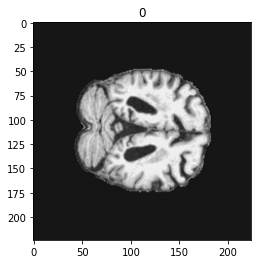

[0,    50] loss: 0.73314
[0,   100] loss: 0.77763
[0,   150] loss: 0.74250
Time elapsed: 0h:0m:35s
train accuracy_score: 53.39 %
val accuracy_score: 57.89 %
Val loss: 0.666426
[1,    50] loss: 0.70245
[1,   100] loss: 0.76528
[1,   150] loss: 0.73676
Time elapsed: 0h:1m:13s
train accuracy_score: 52.06 %
val accuracy_score: 53.95 %
Val loss: 0.848729
[2,    50] loss: 0.73132
[2,   100] loss: 0.70580
[2,   150] loss: 0.71625
Time elapsed: 0h:1m:50s
train accuracy_score: 55.46 %
val accuracy_score: 53.95 %
Val loss: 0.687805
[3,    50] loss: 0.75982
[3,   100] loss: 0.73419
[3,   150] loss: 0.67906
Time elapsed: 0h:2m:27s
train accuracy_score: 54.87 %
val accuracy_score: 52.63 %
Val loss: 0.737649
[4,    50] loss: 0.69255
[4,   100] loss: 0.75054
[4,   150] loss: 0.68169
Time elapsed: 0h:3m:4s
train accuracy_score: 56.78 %
val accuracy_score: 51.32 %
Val loss: 0.685697
[5,    50] loss: 0.67691
[5,   100] loss: 0.72456
[5,   150] loss: 0.75151
Time elapsed: 0h:3m:41s
train accuracy_score: 

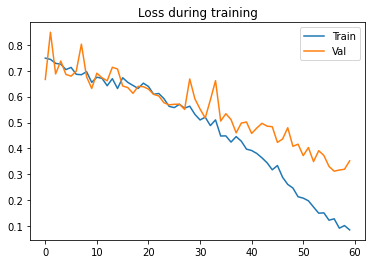

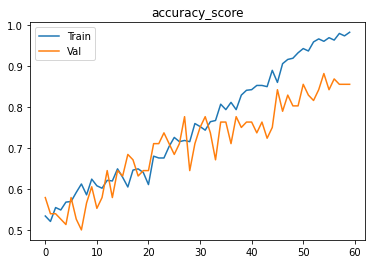

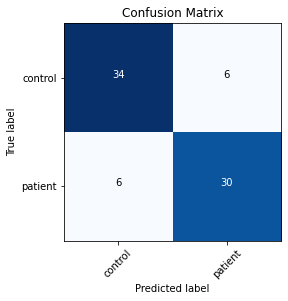

Starting trial 1


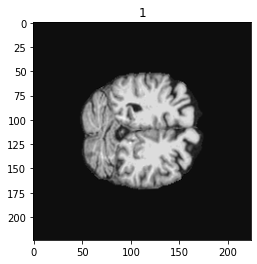

[0,    50] loss: 0.76437
[0,   100] loss: 0.71714
[0,   150] loss: 0.67608
Time elapsed: 0h:0m:35s
train accuracy_score: 55.60 %
val accuracy_score: 57.89 %
Val loss: 0.739044
[1,    50] loss: 0.75843
[1,   100] loss: 0.71991
[1,   150] loss: 0.79176
Time elapsed: 0h:1m:12s
train accuracy_score: 53.39 %
val accuracy_score: 52.63 %
Val loss: 0.732026
[2,    50] loss: 0.74022
[2,   100] loss: 0.80026
[2,   150] loss: 0.71622
Time elapsed: 0h:1m:49s
train accuracy_score: 50.88 %
val accuracy_score: 60.53 %
Val loss: 0.742378
[3,    50] loss: 0.72782
[3,   100] loss: 0.69357
[3,   150] loss: 0.70243
Time elapsed: 0h:2m:27s
train accuracy_score: 55.90 %
val accuracy_score: 56.58 %
Val loss: 0.694684
[4,    50] loss: 0.70615
[4,   100] loss: 0.75592
[4,   150] loss: 0.72578
Time elapsed: 0h:3m:4s
train accuracy_score: 54.87 %
val accuracy_score: 59.21 %
Val loss: 0.712165
[5,    50] loss: 0.72105
[5,   100] loss: 0.70451
[5,   150] loss: 0.74129
Time elapsed: 0h:3m:41s
train accuracy_score: 

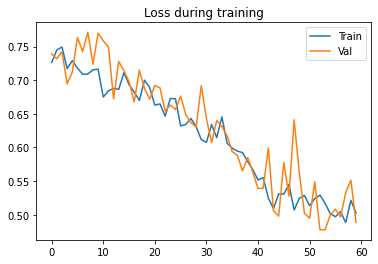

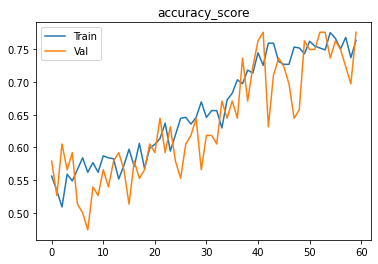

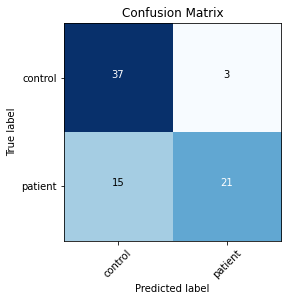

Starting trial 2


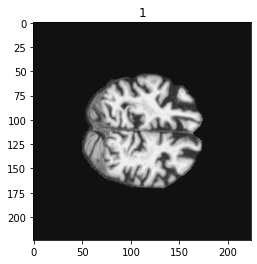

[0,    50] loss: 0.73172
[0,   100] loss: 0.75632
[0,   150] loss: 0.75770
Time elapsed: 0h:0m:35s
train accuracy_score: 50.44 %
val accuracy_score: 52.63 %
Val loss: 0.810931
[1,    50] loss: 0.77959
[1,   100] loss: 0.70759
[1,   150] loss: 0.78266
Time elapsed: 0h:1m:13s
train accuracy_score: 54.42 %
val accuracy_score: 57.89 %
Val loss: 0.730470
[2,    50] loss: 0.72827
[2,   100] loss: 0.75137
[2,   150] loss: 0.77001
Time elapsed: 0h:1m:50s
train accuracy_score: 53.69 %
val accuracy_score: 48.68 %
Val loss: 0.765987
[3,    50] loss: 0.72530
[3,   100] loss: 0.76514
[3,   150] loss: 0.69113
Time elapsed: 0h:2m:27s
train accuracy_score: 56.34 %
val accuracy_score: 46.05 %
Val loss: 0.809766
[4,    50] loss: 0.73256
[4,   100] loss: 0.75396
[4,   150] loss: 0.74571
Time elapsed: 0h:3m:4s
train accuracy_score: 54.87 %
val accuracy_score: 50.00 %
Val loss: 0.881207
[5,    50] loss: 0.77013
[5,   100] loss: 0.70903
[5,   150] loss: 0.73602
Time elapsed: 0h:3m:41s
train accuracy_score: 

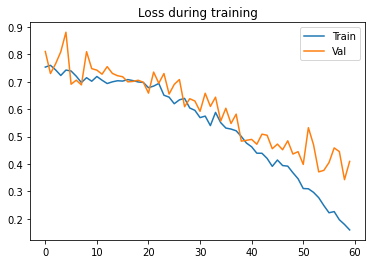

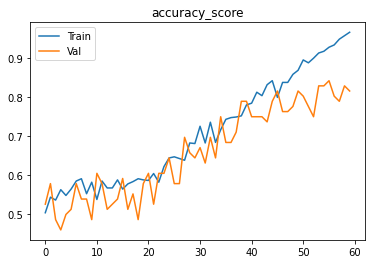

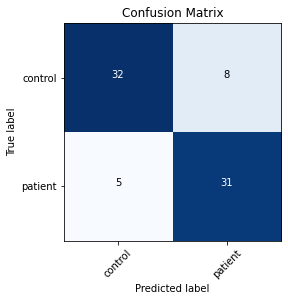

Starting trial 3


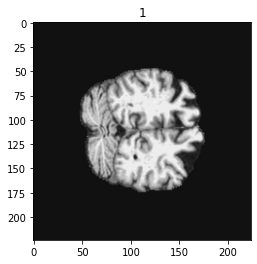

[0,    50] loss: 0.75122
[0,   100] loss: 0.78908
[0,   150] loss: 0.78184
Time elapsed: 0h:0m:36s
train accuracy_score: 51.18 %
val accuracy_score: 53.95 %
Val loss: 0.698029
[1,    50] loss: 0.72241
[1,   100] loss: 0.74334
[1,   150] loss: 0.75265
Time elapsed: 0h:1m:13s
train accuracy_score: 55.90 %
val accuracy_score: 53.95 %
Val loss: 0.720943
[2,    50] loss: 0.72934
[2,   100] loss: 0.71154
[2,   150] loss: 0.77058
Time elapsed: 0h:1m:50s
train accuracy_score: 54.57 %
val accuracy_score: 73.68 %
Val loss: 0.634863
[3,    50] loss: 0.73390
[3,   100] loss: 0.71778
[3,   150] loss: 0.72265
Time elapsed: 0h:2m:28s
train accuracy_score: 54.87 %
val accuracy_score: 53.95 %
Val loss: 0.755120
[4,    50] loss: 0.68854
[4,   100] loss: 0.72520
[4,   150] loss: 0.77219
Time elapsed: 0h:3m:5s
train accuracy_score: 55.75 %
val accuracy_score: 55.26 %
Val loss: 0.792621
[5,    50] loss: 0.76611
[5,   100] loss: 0.67326
[5,   150] loss: 0.75354
Time elapsed: 0h:3m:42s
train accuracy_score: 

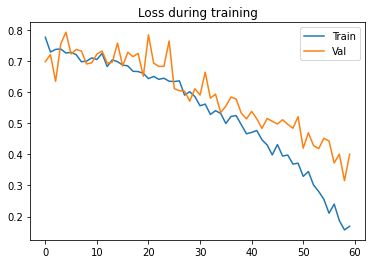

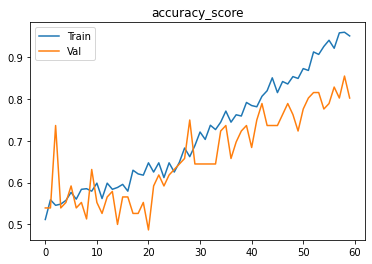

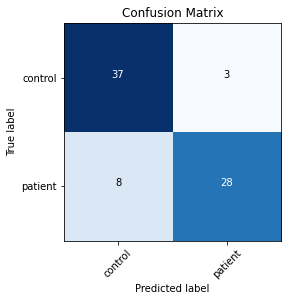

Starting trial 4


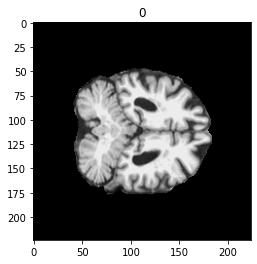

[0,    50] loss: 0.72499
[0,   100] loss: 0.77343
[0,   150] loss: 0.72953
Time elapsed: 0h:0m:35s
train accuracy_score: 53.54 %
val accuracy_score: 48.68 %
Val loss: 0.708856
[1,    50] loss: 0.73192
[1,   100] loss: 0.70260
[1,   150] loss: 0.74449
Time elapsed: 0h:1m:11s
train accuracy_score: 53.39 %
val accuracy_score: 53.95 %
Val loss: 0.856008
[2,    50] loss: 0.75969
[2,   100] loss: 0.66255
[2,   150] loss: 0.72718
Time elapsed: 0h:1m:47s
train accuracy_score: 56.78 %
val accuracy_score: 50.00 %
Val loss: 1.085861
[3,    50] loss: 0.70947
[3,   100] loss: 0.68564
[3,   150] loss: 0.70825
Time elapsed: 0h:2m:24s
train accuracy_score: 55.31 %
val accuracy_score: 63.16 %
Val loss: 0.669876
[4,    50] loss: 0.69049
[4,   100] loss: 0.77632
[4,   150] loss: 0.70475
Time elapsed: 0h:3m:0s
train accuracy_score: 56.05 %
val accuracy_score: 63.16 %
Val loss: 0.676487
[5,    50] loss: 0.74171
[5,   100] loss: 0.73367
[5,   150] loss: 0.72133
Time elapsed: 0h:3m:36s
train accuracy_score: 

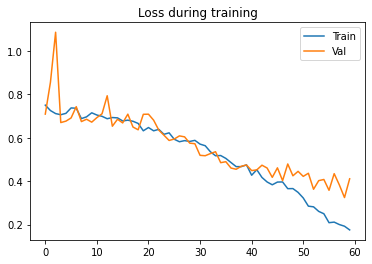

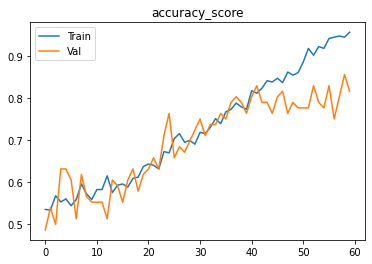

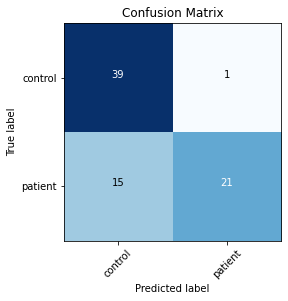

################################
################################
All accuracies: [0.8552631578947368, 0.7763157894736842, 0.8157894736842105, 0.8026315789473685, 0.8157894736842105]
0.8131578947368421
0.025514104512717524
0
Starting slice 1
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


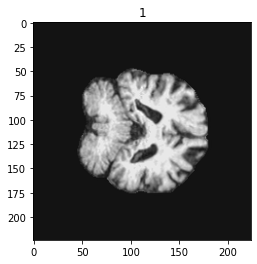

[0,    50] loss: 0.76495
[0,   100] loss: 0.73587
[0,   150] loss: 0.73350
Time elapsed: 0h:0m:35s
train accuracy_score: 52.95 %
val accuracy_score: 55.26 %
Val loss: 0.715886
[1,    50] loss: 0.77807
[1,   100] loss: 0.70918
[1,   150] loss: 0.78364
Time elapsed: 0h:1m:11s
train accuracy_score: 52.51 %
val accuracy_score: 47.37 %
Val loss: 0.810692
[2,    50] loss: 0.72668
[2,   100] loss: 0.70497
[2,   150] loss: 0.74137
Time elapsed: 0h:1m:47s
train accuracy_score: 54.28 %
val accuracy_score: 59.21 %
Val loss: 0.679458
[3,    50] loss: 0.72042
[3,   100] loss: 0.69637
[3,   150] loss: 0.76435
Time elapsed: 0h:2m:23s
train accuracy_score: 57.52 %
val accuracy_score: 55.26 %
Val loss: 0.761142
[4,    50] loss: 0.74021
[4,   100] loss: 0.68660
[4,   150] loss: 0.76098
Time elapsed: 0h:2m:59s
train accuracy_score: 56.05 %
val accuracy_score: 53.95 %
Val loss: 0.711507
[5,    50] loss: 0.67239
[5,   100] loss: 0.66963
[5,   150] loss: 0.73926
Time elapsed: 0h:3m:35s
train accuracy_score:

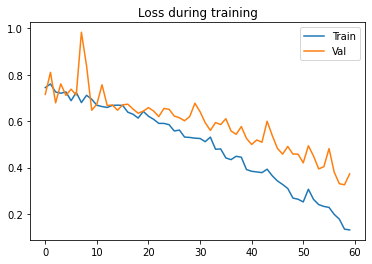

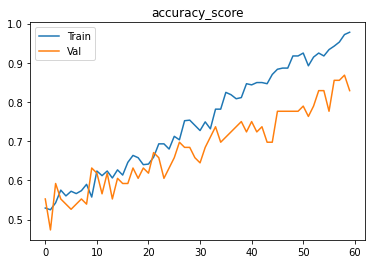

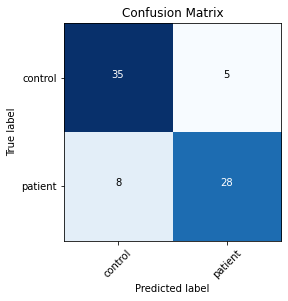

Starting trial 1


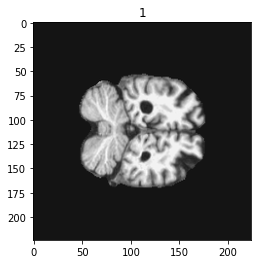

[0,    50] loss: 0.78246
[0,   100] loss: 0.74135
[0,   150] loss: 0.81083
Time elapsed: 0h:0m:34s
train accuracy_score: 51.18 %
val accuracy_score: 60.53 %
Val loss: 0.665146
[1,    50] loss: 0.71880
[1,   100] loss: 0.73349
[1,   150] loss: 0.70363
Time elapsed: 0h:1m:10s
train accuracy_score: 54.28 %
val accuracy_score: 55.26 %
Val loss: 0.713622
[2,    50] loss: 0.73530
[2,   100] loss: 0.70408
[2,   150] loss: 0.71290
Time elapsed: 0h:1m:46s
train accuracy_score: 55.01 %
val accuracy_score: 57.89 %
Val loss: 0.698739
[3,    50] loss: 0.65991
[3,   100] loss: 0.73492
[3,   150] loss: 0.69973
Time elapsed: 0h:2m:22s
train accuracy_score: 58.55 %
val accuracy_score: 59.21 %
Val loss: 0.709706
[4,    50] loss: 0.70976
[4,   100] loss: 0.70059
[4,   150] loss: 0.79031
Time elapsed: 0h:2m:58s
train accuracy_score: 55.01 %
val accuracy_score: 56.58 %
Val loss: 0.689416
[5,    50] loss: 0.73917
[5,   100] loss: 0.72331
[5,   150] loss: 0.71728
Time elapsed: 0h:3m:34s
train accuracy_score:

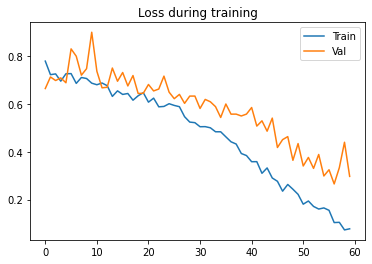

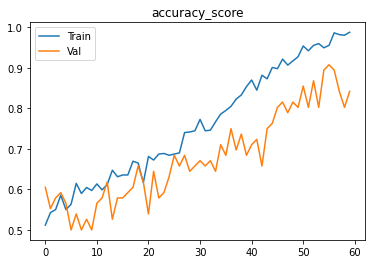

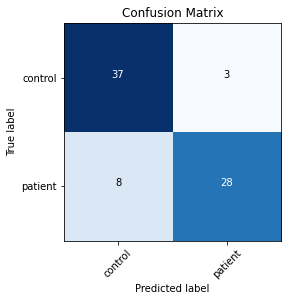

Starting trial 2


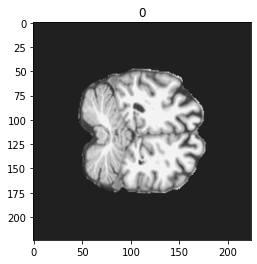

[0,    50] loss: 0.73257
[0,   100] loss: 0.75349
[0,   150] loss: 0.76766
Time elapsed: 0h:0m:35s
train accuracy_score: 54.87 %
val accuracy_score: 57.89 %
Val loss: 0.715315
[1,    50] loss: 0.72781
[1,   100] loss: 0.71964
[1,   150] loss: 0.75125
Time elapsed: 0h:1m:11s
train accuracy_score: 55.60 %
val accuracy_score: 52.63 %
Val loss: 0.729600
[2,    50] loss: 0.72373
[2,   100] loss: 0.73313
[2,   150] loss: 0.72336
Time elapsed: 0h:1m:48s
train accuracy_score: 56.49 %
val accuracy_score: 55.26 %
Val loss: 0.706542
[3,    50] loss: 0.75316
[3,   100] loss: 0.78068
[3,   150] loss: 0.71575
Time elapsed: 0h:2m:25s
train accuracy_score: 55.90 %
val accuracy_score: 59.21 %
Val loss: 0.783007
[4,    50] loss: 0.73006
[4,   100] loss: 0.71145
[4,   150] loss: 0.72466
Time elapsed: 0h:3m:2s
train accuracy_score: 53.98 %
val accuracy_score: 51.32 %
Val loss: 0.717114
[5,    50] loss: 0.72002
[5,   100] loss: 0.71472
[5,   150] loss: 0.66193
Time elapsed: 0h:3m:39s
train accuracy_score: 

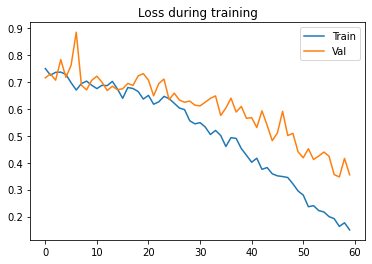

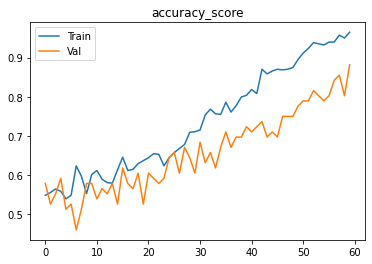

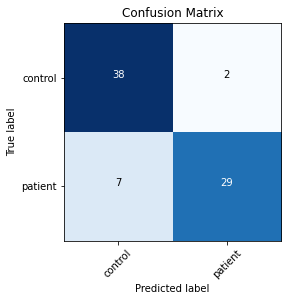

Starting trial 3


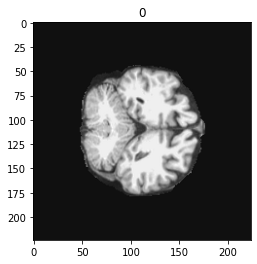

[0,    50] loss: 0.76799
[0,   100] loss: 0.72919
[0,   150] loss: 0.76636
Time elapsed: 0h:0m:34s
train accuracy_score: 50.00 %
val accuracy_score: 52.63 %
Val loss: 0.959004
[1,    50] loss: 0.70247
[1,   100] loss: 0.73274
[1,   150] loss: 0.73485
Time elapsed: 0h:1m:11s
train accuracy_score: 55.90 %
val accuracy_score: 50.00 %
Val loss: 0.775094
[2,    50] loss: 0.75771
[2,   100] loss: 0.68759
[2,   150] loss: 0.74841
Time elapsed: 0h:1m:47s
train accuracy_score: 57.23 %
val accuracy_score: 55.26 %
Val loss: 0.724210
[3,    50] loss: 0.72839
[3,   100] loss: 0.73217
[3,   150] loss: 0.67434
Time elapsed: 0h:2m:23s
train accuracy_score: 54.72 %
val accuracy_score: 63.16 %
Val loss: 0.663959
[4,    50] loss: 0.69668
[4,   100] loss: 0.71375
[4,   150] loss: 0.72478
Time elapsed: 0h:2m:59s
train accuracy_score: 54.42 %
val accuracy_score: 56.58 %
Val loss: 0.709407
[5,    50] loss: 0.76803
[5,   100] loss: 0.74026
[5,   150] loss: 0.66459
Time elapsed: 0h:3m:35s
train accuracy_score:

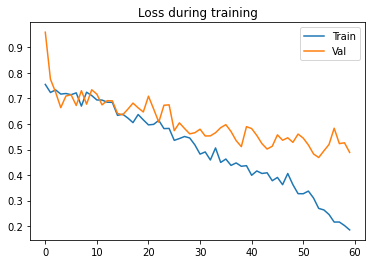

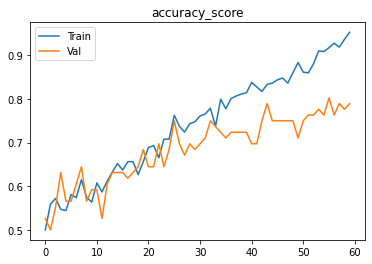

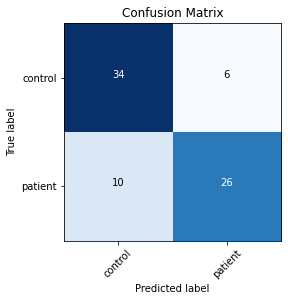

Starting trial 4


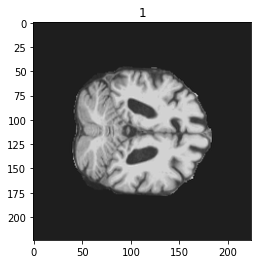

[0,    50] loss: 0.71358
[0,   100] loss: 0.77813
[0,   150] loss: 0.69334
Time elapsed: 0h:0m:35s
train accuracy_score: 54.57 %
val accuracy_score: 53.95 %
Val loss: 0.802139
[1,    50] loss: 0.73375
[1,   100] loss: 0.75793
[1,   150] loss: 0.74650
Time elapsed: 0h:1m:11s
train accuracy_score: 54.28 %
val accuracy_score: 52.63 %
Val loss: 0.724226
[2,    50] loss: 0.67965
[2,   100] loss: 0.71437
[2,   150] loss: 0.82154
Time elapsed: 0h:1m:47s
train accuracy_score: 56.78 %
val accuracy_score: 51.32 %
Val loss: 0.746586
[3,    50] loss: 0.69070
[3,   100] loss: 0.79176
[3,   150] loss: 0.67459
Time elapsed: 0h:2m:24s
train accuracy_score: 57.23 %
val accuracy_score: 50.00 %
Val loss: 0.734063
[4,    50] loss: 0.71845
[4,   100] loss: 0.70876
[4,   150] loss: 0.70541
Time elapsed: 0h:3m:0s
train accuracy_score: 55.90 %
val accuracy_score: 46.05 %
Val loss: 0.728428
[5,    50] loss: 0.70835
[5,   100] loss: 0.67731
[5,   150] loss: 0.70273
Time elapsed: 0h:3m:36s
train accuracy_score: 

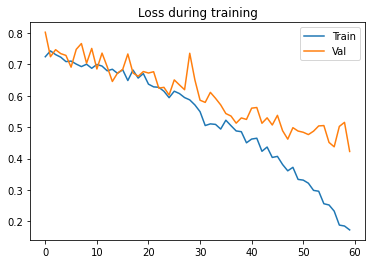

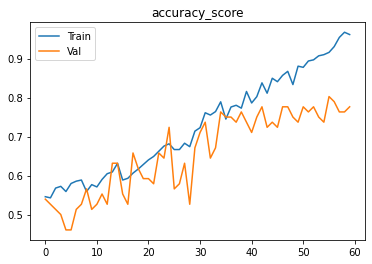

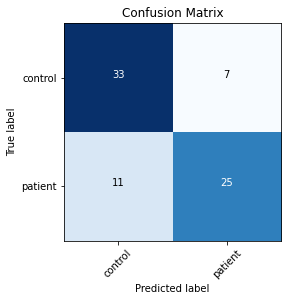

################################
################################
All accuracies: [0.8289473684210527, 0.8421052631578947, 0.881578947368421, 0.7894736842105263, 0.7763157894736842]
0.8236842105263158
0.037770263406335054
2
Starting slice 2
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


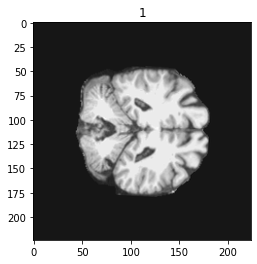

[0,    50] loss: 0.75062
[0,   100] loss: 0.70605
[0,   150] loss: 0.73052
Time elapsed: 0h:0m:35s
train accuracy_score: 55.46 %
val accuracy_score: 47.37 %
Val loss: 0.756375
[1,    50] loss: 0.71413
[1,   100] loss: 0.76356
[1,   150] loss: 0.76074
Time elapsed: 0h:1m:11s
train accuracy_score: 54.42 %
val accuracy_score: 50.00 %
Val loss: 0.717949
[2,    50] loss: 0.74465
[2,   100] loss: 0.74383
[2,   150] loss: 0.73078
Time elapsed: 0h:1m:47s
train accuracy_score: 55.01 %
val accuracy_score: 55.26 %
Val loss: 0.794055
[3,    50] loss: 0.72392
[3,   100] loss: 0.75954
[3,   150] loss: 0.68828
Time elapsed: 0h:2m:23s
train accuracy_score: 54.87 %
val accuracy_score: 50.00 %
Val loss: 0.753225
[4,    50] loss: 0.77007
[4,   100] loss: 0.71892
[4,   150] loss: 0.72159
Time elapsed: 0h:3m:0s
train accuracy_score: 55.16 %
val accuracy_score: 53.95 %
Val loss: 0.707032
[5,    50] loss: 0.75690
[5,   100] loss: 0.70224
[5,   150] loss: 0.74429
Time elapsed: 0h:3m:36s
train accuracy_score: 

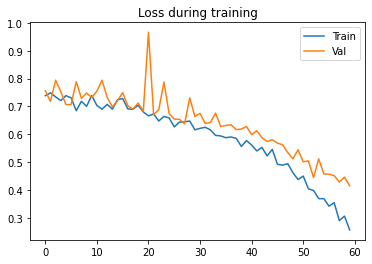

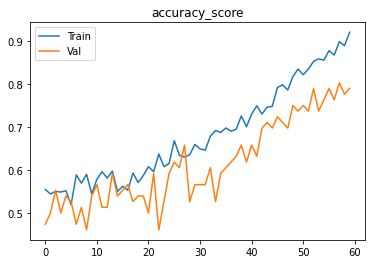

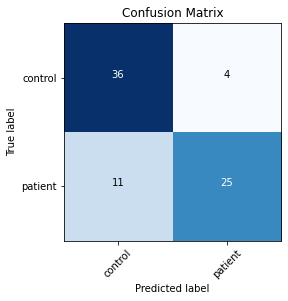

Starting trial 1


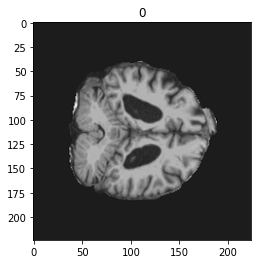

[0,    50] loss: 0.81273
[0,   100] loss: 0.72149
[0,   150] loss: 0.68915
Time elapsed: 0h:0m:34s
train accuracy_score: 56.34 %
val accuracy_score: 53.95 %
Val loss: 0.783539
[1,    50] loss: 0.76665
[1,   100] loss: 0.74685
[1,   150] loss: 0.72052
Time elapsed: 0h:1m:10s
train accuracy_score: 54.42 %
val accuracy_score: 55.26 %
Val loss: 0.724805
[2,    50] loss: 0.74146
[2,   100] loss: 0.72398
[2,   150] loss: 0.68130
Time elapsed: 0h:1m:46s
train accuracy_score: 58.41 %
val accuracy_score: 56.58 %
Val loss: 0.775939
[3,    50] loss: 0.70033
[3,   100] loss: 0.69042
[3,   150] loss: 0.73696
Time elapsed: 0h:2m:22s
train accuracy_score: 55.60 %
val accuracy_score: 46.05 %
Val loss: 0.716861
[4,    50] loss: 0.72067
[4,   100] loss: 0.73619
[4,   150] loss: 0.69383
Time elapsed: 0h:2m:59s
train accuracy_score: 58.41 %
val accuracy_score: 56.58 %
Val loss: 0.794533
[5,    50] loss: 0.72163
[5,   100] loss: 0.70189
[5,   150] loss: 0.69793
Time elapsed: 0h:3m:35s
train accuracy_score:

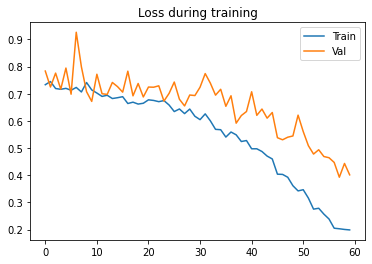

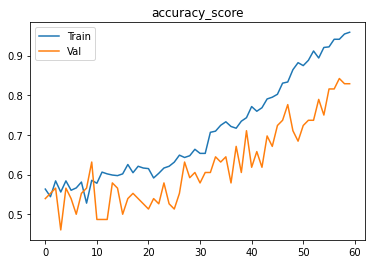

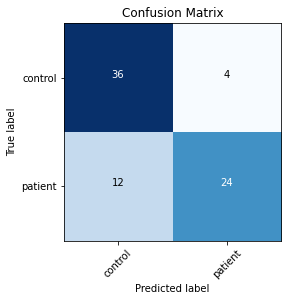

Starting trial 2


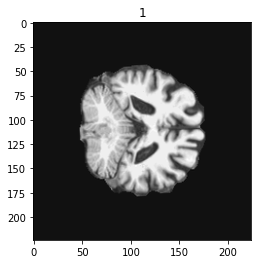

[0,    50] loss: 0.77686
[0,   100] loss: 0.74845
[0,   150] loss: 0.72891
Time elapsed: 0h:0m:34s
train accuracy_score: 51.92 %
val accuracy_score: 52.63 %
Val loss: 0.875994
[1,    50] loss: 0.71940
[1,   100] loss: 0.71906
[1,   150] loss: 0.76595
Time elapsed: 0h:1m:10s
train accuracy_score: 55.16 %
val accuracy_score: 53.95 %
Val loss: 0.732951
[2,    50] loss: 0.73130
[2,   100] loss: 0.74412
[2,   150] loss: 0.73146
Time elapsed: 0h:1m:46s
train accuracy_score: 53.98 %
val accuracy_score: 51.32 %
Val loss: 0.744826
[3,    50] loss: 0.74275
[3,   100] loss: 0.74418
[3,   150] loss: 0.71536
Time elapsed: 0h:2m:23s
train accuracy_score: 55.31 %
val accuracy_score: 52.63 %
Val loss: 0.727776
[4,    50] loss: 0.71780
[4,   100] loss: 0.72336
[4,   150] loss: 0.74918
Time elapsed: 0h:2m:59s
train accuracy_score: 56.19 %
val accuracy_score: 51.32 %
Val loss: 0.719536
[5,    50] loss: 0.74163
[5,   100] loss: 0.70096
[5,   150] loss: 0.73406
Time elapsed: 0h:3m:34s
train accuracy_score:

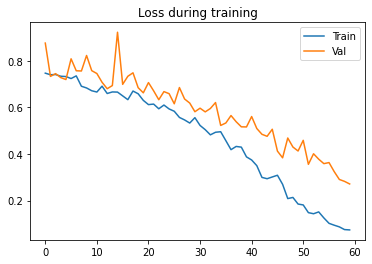

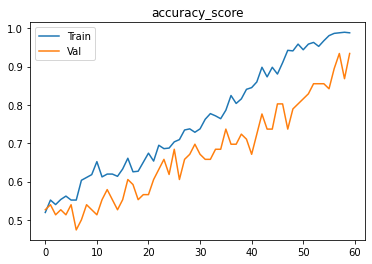

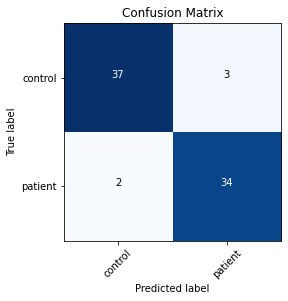

Starting trial 3


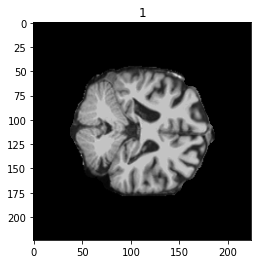

[0,    50] loss: 0.77554
[0,   100] loss: 0.71351
[0,   150] loss: 0.73069
Time elapsed: 0h:0m:35s
train accuracy_score: 54.13 %
val accuracy_score: 50.00 %
Val loss: 0.714315
[1,    50] loss: 0.74323
[1,   100] loss: 0.74063
[1,   150] loss: 0.76215
Time elapsed: 0h:1m:11s
train accuracy_score: 53.10 %
val accuracy_score: 48.68 %
Val loss: 0.750473
[2,    50] loss: 0.72761
[2,   100] loss: 0.74592
[2,   150] loss: 0.71579
Time elapsed: 0h:1m:47s
train accuracy_score: 56.19 %
val accuracy_score: 53.95 %
Val loss: 0.807553
[3,    50] loss: 0.72642
[3,   100] loss: 0.73406
[3,   150] loss: 0.73546
Time elapsed: 0h:2m:23s
train accuracy_score: 57.23 %
val accuracy_score: 55.26 %
Val loss: 0.730688
[4,    50] loss: 0.75298
[4,   100] loss: 0.71224
[4,   150] loss: 0.72924
Time elapsed: 0h:3m:0s
train accuracy_score: 55.16 %
val accuracy_score: 53.95 %
Val loss: 0.726658
[5,    50] loss: 0.70358
[5,   100] loss: 0.72259
[5,   150] loss: 0.72122
Time elapsed: 0h:3m:36s
train accuracy_score: 

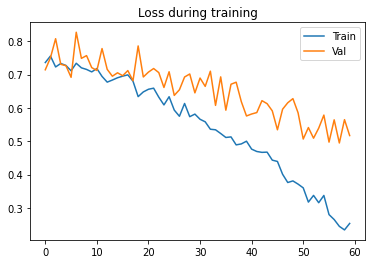

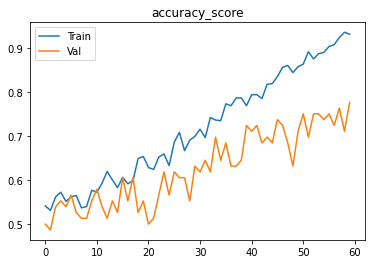

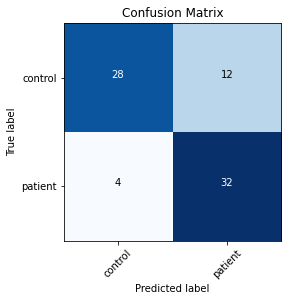

Starting trial 4


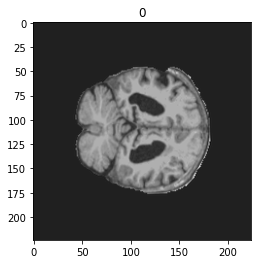

[0,    50] loss: 0.75587
[0,   100] loss: 0.74243
[0,   150] loss: 0.71427
Time elapsed: 0h:0m:34s
train accuracy_score: 56.78 %
val accuracy_score: 48.68 %
Val loss: 0.760730
[1,    50] loss: 0.74217
[1,   100] loss: 0.70835
[1,   150] loss: 0.75320
Time elapsed: 0h:1m:10s
train accuracy_score: 56.19 %
val accuracy_score: 52.63 %
Val loss: 0.821729
[2,    50] loss: 0.74942
[2,   100] loss: 0.67005
[2,   150] loss: 0.66607
Time elapsed: 0h:1m:46s
train accuracy_score: 59.29 %
val accuracy_score: 47.37 %
Val loss: 0.848426
[3,    50] loss: 0.66745
[3,   100] loss: 0.73971
[3,   150] loss: 0.71949
Time elapsed: 0h:2m:22s
train accuracy_score: 57.23 %
val accuracy_score: 46.05 %
Val loss: 0.747707
[4,    50] loss: 0.69820
[4,   100] loss: 0.72341
[4,   150] loss: 0.73689
Time elapsed: 0h:2m:58s
train accuracy_score: 57.23 %
val accuracy_score: 56.58 %
Val loss: 0.767106
[5,    50] loss: 0.72872
[5,   100] loss: 0.67548
[5,   150] loss: 0.74003
Time elapsed: 0h:3m:34s
train accuracy_score:

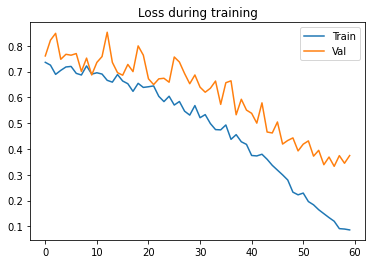

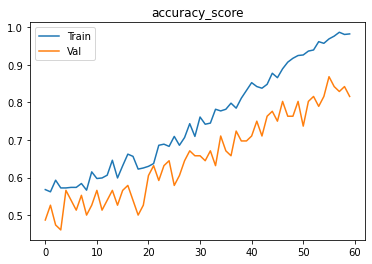

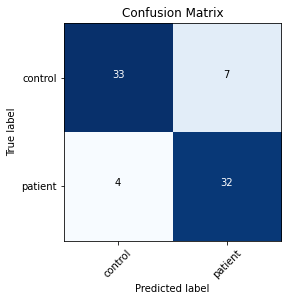

################################
################################
All accuracies: [0.7894736842105263, 0.8289473684210527, 0.9342105263157895, 0.7763157894736842, 0.8157894736842105]
0.8289473684210525
0.05582421956735903
2
Starting slice 3
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


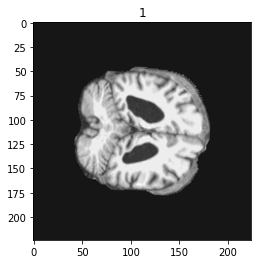

[0,    50] loss: 0.72317
[0,   100] loss: 0.78316
[0,   150] loss: 0.74159
Time elapsed: 0h:0m:34s
train accuracy_score: 51.62 %
val accuracy_score: 57.89 %
Val loss: 0.728243
[1,    50] loss: 0.71570
[1,   100] loss: 0.74467
[1,   150] loss: 0.70069
Time elapsed: 0h:1m:10s
train accuracy_score: 56.49 %
val accuracy_score: 44.74 %
Val loss: 0.778174
[2,    50] loss: 0.72698
[2,   100] loss: 0.71086
[2,   150] loss: 0.73573
Time elapsed: 0h:1m:46s
train accuracy_score: 56.78 %
val accuracy_score: 46.05 %
Val loss: 0.719323
[3,    50] loss: 0.74422
[3,   100] loss: 0.70889
[3,   150] loss: 0.74616
Time elapsed: 0h:2m:22s
train accuracy_score: 57.37 %
val accuracy_score: 50.00 %
Val loss: 0.986859
[4,    50] loss: 0.69987
[4,   100] loss: 0.73205
[4,   150] loss: 0.73888
Time elapsed: 0h:2m:58s
train accuracy_score: 57.37 %
val accuracy_score: 55.26 %
Val loss: 0.754397
[5,    50] loss: 0.69145
[5,   100] loss: 0.69168
[5,   150] loss: 0.75330
Time elapsed: 0h:3m:34s
train accuracy_score:

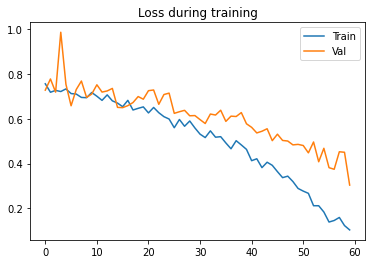

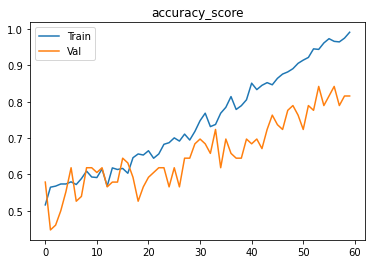

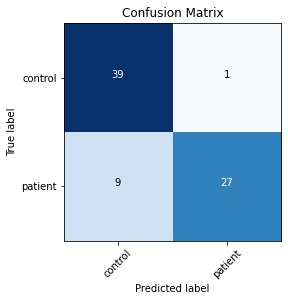

Starting trial 1


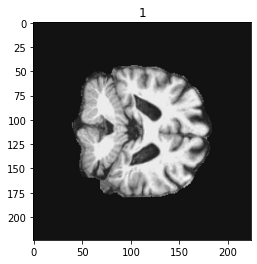

[0,    50] loss: 0.76223
[0,   100] loss: 0.69948
[0,   150] loss: 0.78651
Time elapsed: 0h:0m:35s
train accuracy_score: 54.13 %
val accuracy_score: 44.74 %
Val loss: 0.760217
[1,    50] loss: 0.74547
[1,   100] loss: 0.78282
[1,   150] loss: 0.75626
Time elapsed: 0h:1m:12s
train accuracy_score: 54.87 %
val accuracy_score: 53.95 %
Val loss: 0.821757
[2,    50] loss: 0.73535
[2,   100] loss: 0.71624
[2,   150] loss: 0.69559
Time elapsed: 0h:1m:49s
train accuracy_score: 59.29 %
val accuracy_score: 55.26 %
Val loss: 0.786949
[3,    50] loss: 0.67983
[3,   100] loss: 0.74440
[3,   150] loss: 0.73194
Time elapsed: 0h:2m:26s
train accuracy_score: 56.64 %
val accuracy_score: 60.53 %
Val loss: 0.689795
[4,    50] loss: 0.73527
[4,   100] loss: 0.74513
[4,   150] loss: 0.75930
Time elapsed: 0h:3m:3s
train accuracy_score: 55.60 %
val accuracy_score: 53.95 %
Val loss: 0.682649
[5,    50] loss: 0.76672
[5,   100] loss: 0.70220
[5,   150] loss: 0.75474
Time elapsed: 0h:3m:40s
train accuracy_score: 

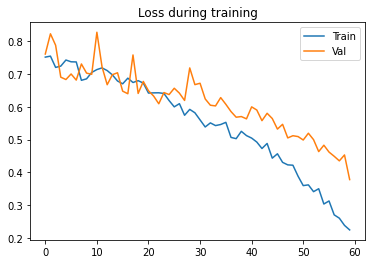

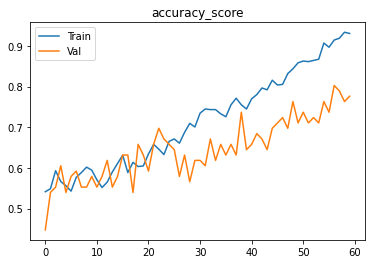

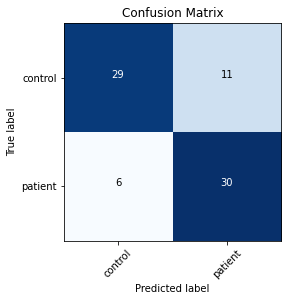

Starting trial 2


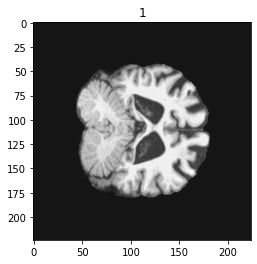

[0,    50] loss: 0.82498
[0,   100] loss: 0.78114
[0,   150] loss: 0.77159
Time elapsed: 0h:0m:35s
train accuracy_score: 50.59 %
val accuracy_score: 60.53 %
Val loss: 0.859012
[1,    50] loss: 0.70077
[1,   100] loss: 0.78000
[1,   150] loss: 0.72444
Time elapsed: 0h:1m:12s
train accuracy_score: 54.28 %
val accuracy_score: 60.53 %
Val loss: 0.719744
[2,    50] loss: 0.74737
[2,   100] loss: 0.77938
[2,   150] loss: 0.75023
Time elapsed: 0h:1m:49s
train accuracy_score: 52.65 %
val accuracy_score: 53.95 %
Val loss: 0.794661
[3,    50] loss: 0.72120
[3,   100] loss: 0.77389
[3,   150] loss: 0.73098
Time elapsed: 0h:2m:26s
train accuracy_score: 53.69 %
val accuracy_score: 48.68 %
Val loss: 0.812403
[4,    50] loss: 0.73901
[4,   100] loss: 0.73019
[4,   150] loss: 0.74043
Time elapsed: 0h:3m:3s
train accuracy_score: 52.36 %
val accuracy_score: 39.47 %
Val loss: 0.756648
[5,    50] loss: 0.70779
[5,   100] loss: 0.69433
[5,   150] loss: 0.68794
Time elapsed: 0h:3m:40s
train accuracy_score: 

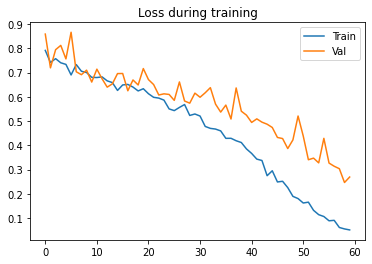

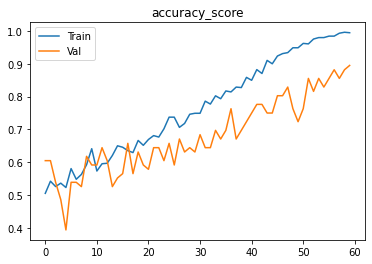

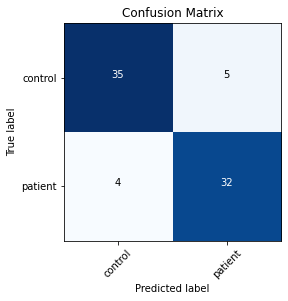

Starting trial 3


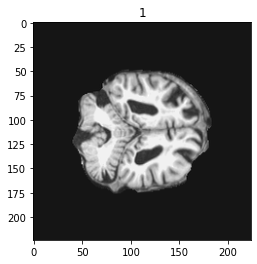

[0,    50] loss: 0.71740
[0,   100] loss: 0.69995
[0,   150] loss: 0.69801
Time elapsed: 0h:0m:35s
train accuracy_score: 56.49 %
val accuracy_score: 57.89 %
Val loss: 0.701359
[1,    50] loss: 0.75991
[1,   100] loss: 0.71623
[1,   150] loss: 0.74612
Time elapsed: 0h:1m:12s
train accuracy_score: 53.83 %
val accuracy_score: 57.89 %
Val loss: 0.732081
[2,    50] loss: 0.74359
[2,   100] loss: 0.79139
[2,   150] loss: 0.73942
Time elapsed: 0h:1m:50s
train accuracy_score: 53.69 %
val accuracy_score: 56.58 %
Val loss: 0.749836
[3,    50] loss: 0.75798
[3,   100] loss: 0.74076
[3,   150] loss: 0.72916
Time elapsed: 0h:2m:27s
train accuracy_score: 58.26 %
val accuracy_score: 60.53 %
Val loss: 0.652113
[4,    50] loss: 0.76432
[4,   100] loss: 0.71186
[4,   150] loss: 0.77121
Time elapsed: 0h:3m:4s
train accuracy_score: 53.69 %
val accuracy_score: 60.53 %
Val loss: 0.738663
[5,    50] loss: 0.74168
[5,   100] loss: 0.70221
[5,   150] loss: 0.70084
Time elapsed: 0h:3m:41s
train accuracy_score: 

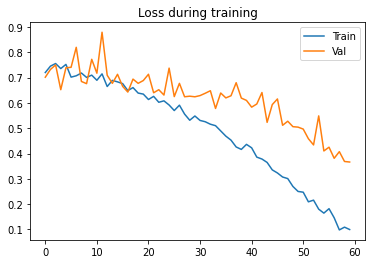

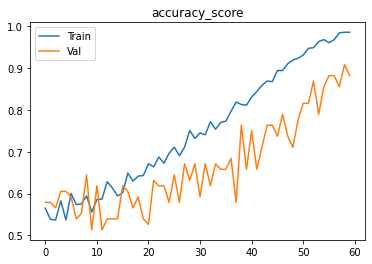

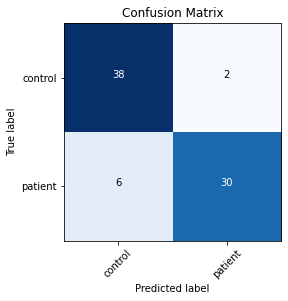

Starting trial 4


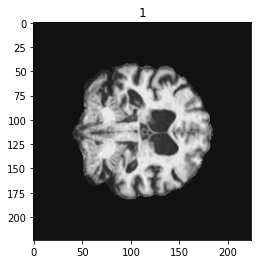

[0,    50] loss: 0.74515
[0,   100] loss: 0.76614
[0,   150] loss: 0.79581
Time elapsed: 0h:0m:35s
train accuracy_score: 53.98 %
val accuracy_score: 51.32 %
Val loss: 0.846248
[1,    50] loss: 0.74851
[1,   100] loss: 0.71082
[1,   150] loss: 0.71122
Time elapsed: 0h:1m:12s
train accuracy_score: 55.75 %
val accuracy_score: 48.68 %
Val loss: 0.741758
[2,    50] loss: 0.73735
[2,   100] loss: 0.72357
[2,   150] loss: 0.71043
Time elapsed: 0h:1m:49s
train accuracy_score: 55.31 %
val accuracy_score: 56.58 %
Val loss: 0.779851
[3,    50] loss: 0.68458
[3,   100] loss: 0.72414
[3,   150] loss: 0.75135
Time elapsed: 0h:2m:26s
train accuracy_score: 56.05 %
val accuracy_score: 51.32 %
Val loss: 0.728160
[4,    50] loss: 0.78477
[4,   100] loss: 0.68904
[4,   150] loss: 0.72103
Time elapsed: 0h:3m:3s
train accuracy_score: 54.57 %
val accuracy_score: 50.00 %
Val loss: 0.691289
[5,    50] loss: 0.70005
[5,   100] loss: 0.78359
[5,   150] loss: 0.73078
Time elapsed: 0h:3m:40s
train accuracy_score: 

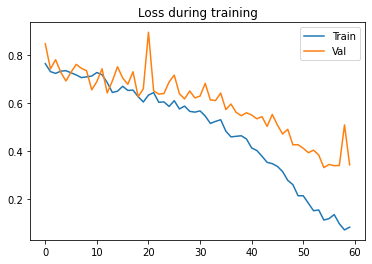

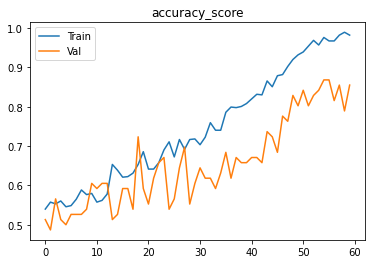

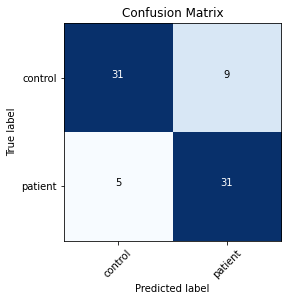

################################
################################
All accuracies: [0.8157894736842105, 0.7763157894736842, 0.8947368421052632, 0.881578947368421, 0.8552631578947368]
0.8447368421052632
0.04356038251907066
2
Starting slice 4
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


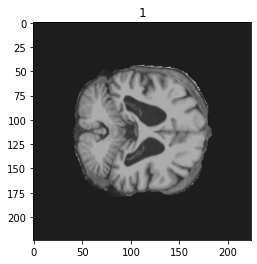

[0,    50] loss: 0.76363
[0,   100] loss: 0.75049
[0,   150] loss: 0.77374
Time elapsed: 0h:0m:35s
train accuracy_score: 50.74 %
val accuracy_score: 51.32 %
Val loss: 0.748077
[1,    50] loss: 0.71310
[1,   100] loss: 0.75391
[1,   150] loss: 0.73171
Time elapsed: 0h:1m:13s
train accuracy_score: 53.54 %
val accuracy_score: 60.53 %
Val loss: 0.722166
[2,    50] loss: 0.75091
[2,   100] loss: 0.68939
[2,   150] loss: 0.74362
Time elapsed: 0h:1m:50s
train accuracy_score: 54.72 %
val accuracy_score: 64.47 %
Val loss: 0.684820
[3,    50] loss: 0.71571
[3,   100] loss: 0.73268
[3,   150] loss: 0.73681
Time elapsed: 0h:2m:27s
train accuracy_score: 53.24 %
val accuracy_score: 55.26 %
Val loss: 0.708188
[4,    50] loss: 0.74785
[4,   100] loss: 0.74441
[4,   150] loss: 0.74939
Time elapsed: 0h:3m:5s
train accuracy_score: 55.46 %
val accuracy_score: 65.79 %
Val loss: 0.702586
[5,    50] loss: 0.75810
[5,   100] loss: 0.75841
[5,   150] loss: 0.71755
Time elapsed: 0h:3m:43s
train accuracy_score: 

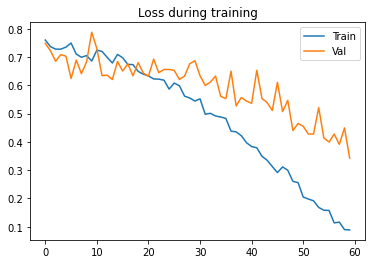

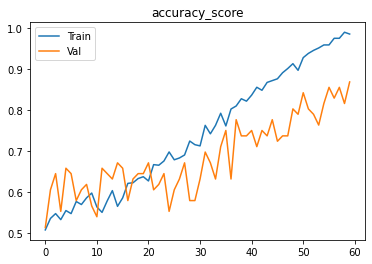

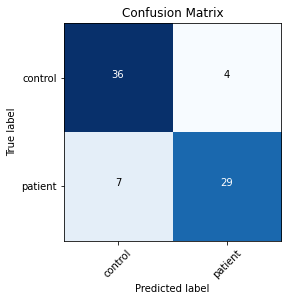

Starting trial 1


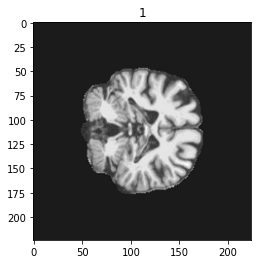

[0,    50] loss: 0.76725
[0,   100] loss: 0.76597
[0,   150] loss: 0.77227
Time elapsed: 0h:0m:35s
train accuracy_score: 50.29 %
val accuracy_score: 60.53 %
Val loss: 0.667131
[1,    50] loss: 0.73272
[1,   100] loss: 0.69278
[1,   150] loss: 0.76228
Time elapsed: 0h:1m:12s
train accuracy_score: 56.05 %
val accuracy_score: 56.58 %
Val loss: 0.713549
[2,    50] loss: 0.68938
[2,   100] loss: 0.76009
[2,   150] loss: 0.74468
Time elapsed: 0h:1m:49s
train accuracy_score: 56.19 %
val accuracy_score: 56.58 %
Val loss: 0.736086
[3,    50] loss: 0.74315
[3,   100] loss: 0.67293
[3,   150] loss: 0.79111
Time elapsed: 0h:2m:26s
train accuracy_score: 55.31 %
val accuracy_score: 57.89 %
Val loss: 0.692587
[4,    50] loss: 0.73297
[4,   100] loss: 0.72840
[4,   150] loss: 0.75430
Time elapsed: 0h:3m:3s
train accuracy_score: 54.87 %
val accuracy_score: 50.00 %
Val loss: 0.719380
[5,    50] loss: 0.73198
[5,   100] loss: 0.71442
[5,   150] loss: 0.71592
Time elapsed: 0h:3m:39s
train accuracy_score: 

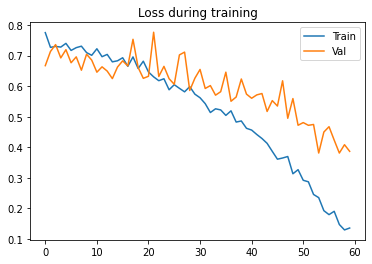

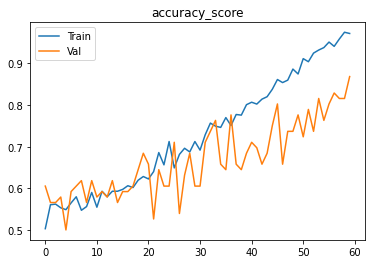

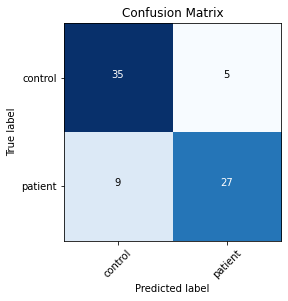

Starting trial 2


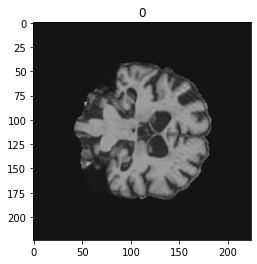

[0,    50] loss: 0.76237
[0,   100] loss: 0.70875
[0,   150] loss: 0.74986
Time elapsed: 0h:0m:35s
train accuracy_score: 56.19 %
val accuracy_score: 48.68 %
Val loss: 0.706812
[1,    50] loss: 0.69764
[1,   100] loss: 0.78706
[1,   150] loss: 0.72215
Time elapsed: 0h:1m:12s
train accuracy_score: 52.51 %
val accuracy_score: 61.84 %
Val loss: 0.998144
[2,    50] loss: 0.69631
[2,   100] loss: 0.79768
[2,   150] loss: 0.75365
Time elapsed: 0h:1m:49s
train accuracy_score: 56.34 %
val accuracy_score: 53.95 %
Val loss: 0.846515
[3,    50] loss: 0.78003
[3,   100] loss: 0.77894
[3,   150] loss: 0.71906
Time elapsed: 0h:2m:25s
train accuracy_score: 52.80 %
val accuracy_score: 53.95 %
Val loss: 0.723543
[4,    50] loss: 0.74762
[4,   100] loss: 0.64806
[4,   150] loss: 0.74194
Time elapsed: 0h:3m:2s
train accuracy_score: 56.64 %
val accuracy_score: 59.21 %
Val loss: 0.693522
[5,    50] loss: 0.73539
[5,   100] loss: 0.66598
[5,   150] loss: 0.75065
Time elapsed: 0h:3m:39s
train accuracy_score: 

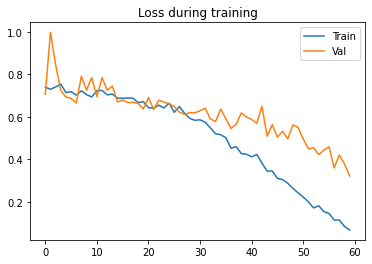

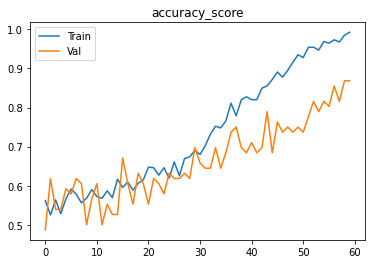

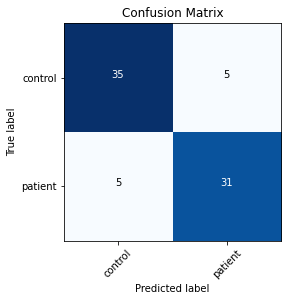

Starting trial 3


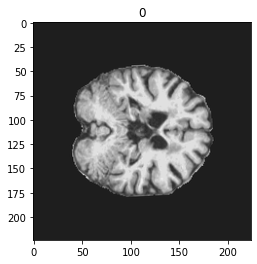

[0,    50] loss: 0.74709
[0,   100] loss: 0.77587
[0,   150] loss: 0.71726
Time elapsed: 0h:0m:35s
train accuracy_score: 52.95 %
val accuracy_score: 52.63 %
Val loss: 0.723492
[1,    50] loss: 0.72852
[1,   100] loss: 0.72073
[1,   150] loss: 0.70330
Time elapsed: 0h:1m:12s
train accuracy_score: 55.90 %
val accuracy_score: 55.26 %
Val loss: 0.722829
[2,    50] loss: 0.73739
[2,   100] loss: 0.70413
[2,   150] loss: 0.74994
Time elapsed: 0h:1m:50s
train accuracy_score: 55.16 %
val accuracy_score: 61.84 %
Val loss: 0.657673
[3,    50] loss: 0.72791
[3,   100] loss: 0.75397
[3,   150] loss: 0.73161
Time elapsed: 0h:2m:27s
train accuracy_score: 52.95 %
val accuracy_score: 56.58 %
Val loss: 0.699340
[4,    50] loss: 0.79407
[4,   100] loss: 0.76993
[4,   150] loss: 0.76093
Time elapsed: 0h:3m:4s
train accuracy_score: 52.95 %
val accuracy_score: 63.16 %
Val loss: 0.663422
[5,    50] loss: 0.74474
[5,   100] loss: 0.71861
[5,   150] loss: 0.74208
Time elapsed: 0h:3m:41s
train accuracy_score: 

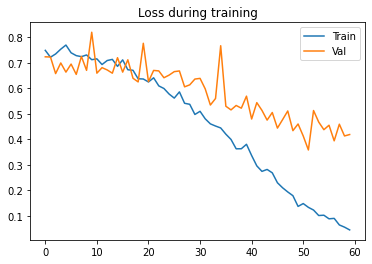

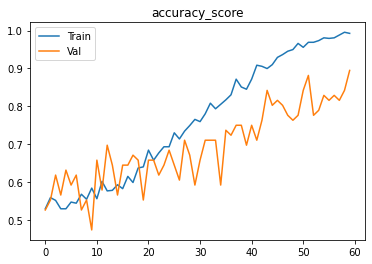

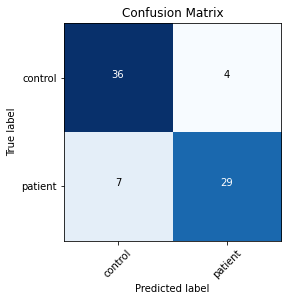

Starting trial 4


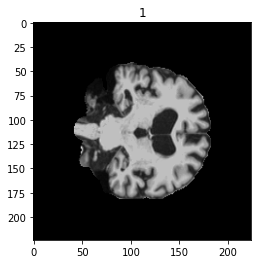

[0,    50] loss: 0.74784
[0,   100] loss: 0.80121
[0,   150] loss: 0.78154
Time elapsed: 0h:0m:35s
train accuracy_score: 52.06 %
val accuracy_score: 51.32 %
Val loss: 0.685305
[1,    50] loss: 0.73753
[1,   100] loss: 0.72283
[1,   150] loss: 0.74897
Time elapsed: 0h:1m:12s
train accuracy_score: 53.39 %
val accuracy_score: 38.16 %
Val loss: 0.941456
[2,    50] loss: 0.80957
[2,   100] loss: 0.74975
[2,   150] loss: 0.73195
Time elapsed: 0h:1m:49s
train accuracy_score: 53.10 %
val accuracy_score: 47.37 %
Val loss: 0.728598
[3,    50] loss: 0.76180
[3,   100] loss: 0.71016
[3,   150] loss: 0.71078
Time elapsed: 0h:2m:26s
train accuracy_score: 55.60 %
val accuracy_score: 51.32 %
Val loss: 0.695270
[4,    50] loss: 0.72903
[4,   100] loss: 0.74694
[4,   150] loss: 0.74798
Time elapsed: 0h:3m:3s
train accuracy_score: 56.78 %
val accuracy_score: 59.21 %
Val loss: 0.693184
[5,    50] loss: 0.71625
[5,   100] loss: 0.70226
[5,   150] loss: 0.74051
Time elapsed: 0h:3m:40s
train accuracy_score: 

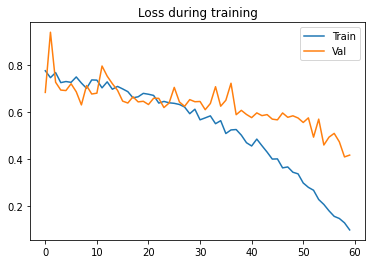

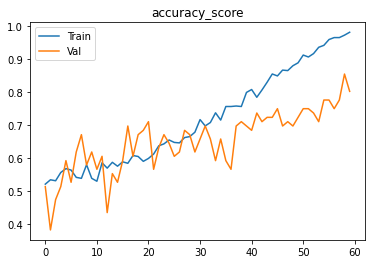

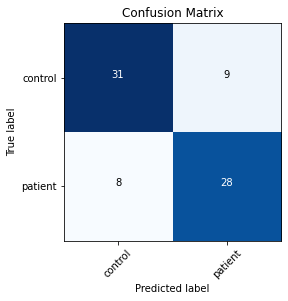

################################
################################
All accuracies: [0.868421052631579, 0.868421052631579, 0.868421052631579, 0.8947368421052632, 0.8026315789473685]
0.8605263157894738
0.03068922049918578
3
Starting slice 5
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


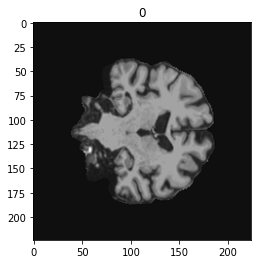

[0,    50] loss: 0.79900
[0,   100] loss: 0.71000
[0,   150] loss: 0.75469
Time elapsed: 0h:0m:35s
train accuracy_score: 51.92 %
val accuracy_score: 61.84 %
Val loss: 0.675970
[1,    50] loss: 0.71209
[1,   100] loss: 0.74957
[1,   150] loss: 0.72193
Time elapsed: 0h:1m:12s
train accuracy_score: 56.49 %
val accuracy_score: 59.21 %
Val loss: 0.701376
[2,    50] loss: 0.73630
[2,   100] loss: 0.70732
[2,   150] loss: 0.77746
Time elapsed: 0h:1m:48s
train accuracy_score: 53.10 %
val accuracy_score: 50.00 %
Val loss: 0.717164
[3,    50] loss: 0.74425
[3,   100] loss: 0.73053
[3,   150] loss: 0.72423
Time elapsed: 0h:2m:25s
train accuracy_score: 53.10 %
val accuracy_score: 56.58 %
Val loss: 0.674608
[4,    50] loss: 0.75201
[4,   100] loss: 0.73444
[4,   150] loss: 0.77232
Time elapsed: 0h:3m:2s
train accuracy_score: 52.65 %
val accuracy_score: 56.58 %
Val loss: 0.995622
[5,    50] loss: 0.74459
[5,   100] loss: 0.68080
[5,   150] loss: 0.71735
Time elapsed: 0h:3m:38s
train accuracy_score: 

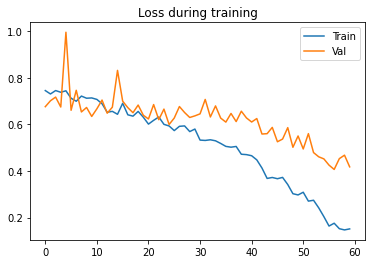

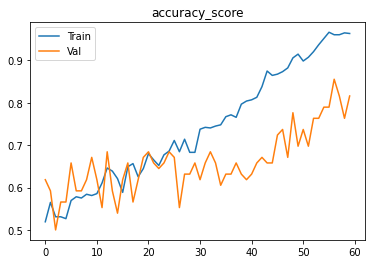

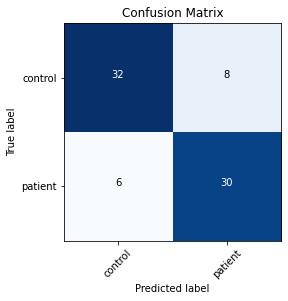

Starting trial 1


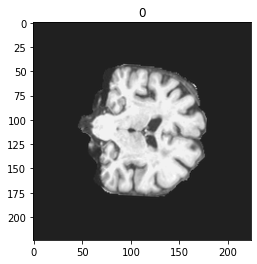

[0,    50] loss: 0.78781
[0,   100] loss: 0.79661
[0,   150] loss: 0.73115
Time elapsed: 0h:0m:35s
train accuracy_score: 49.71 %
val accuracy_score: 48.68 %
Val loss: 1.151960
[1,    50] loss: 0.77171
[1,   100] loss: 0.84853
[1,   150] loss: 0.74059
Time elapsed: 0h:1m:12s
train accuracy_score: 51.03 %
val accuracy_score: 51.32 %
Val loss: 0.716017
[2,    50] loss: 0.76934
[2,   100] loss: 0.71436
[2,   150] loss: 0.66997
Time elapsed: 0h:1m:49s
train accuracy_score: 58.85 %
val accuracy_score: 57.89 %
Val loss: 0.705635
[3,    50] loss: 0.73985
[3,   100] loss: 0.73354
[3,   150] loss: 0.80373
Time elapsed: 0h:2m:26s
train accuracy_score: 52.80 %
val accuracy_score: 53.95 %
Val loss: 0.718098
[4,    50] loss: 0.66394
[4,   100] loss: 0.68325
[4,   150] loss: 0.74903
Time elapsed: 0h:3m:3s
train accuracy_score: 57.23 %
val accuracy_score: 61.84 %
Val loss: 0.647555
[5,    50] loss: 0.75933
[5,   100] loss: 0.75807
[5,   150] loss: 0.73721
Time elapsed: 0h:3m:40s
train accuracy_score: 

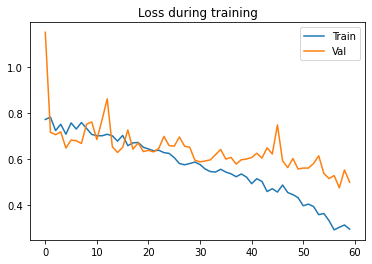

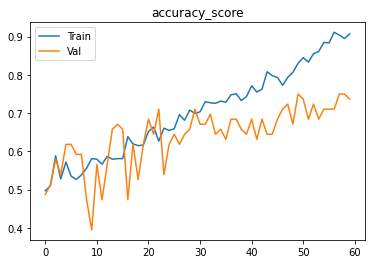

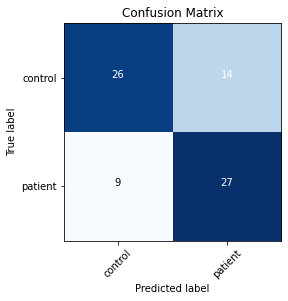

Starting trial 2


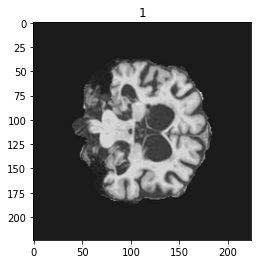

[0,    50] loss: 0.75210
[0,   100] loss: 0.73934
[0,   150] loss: 0.78972
Time elapsed: 0h:0m:36s
train accuracy_score: 53.98 %
val accuracy_score: 63.16 %
Val loss: 0.745784
[1,    50] loss: 0.79967
[1,   100] loss: 0.77851
[1,   150] loss: 0.78404
Time elapsed: 0h:1m:13s
train accuracy_score: 51.92 %
val accuracy_score: 55.26 %
Val loss: 0.744689
[2,    50] loss: 0.73680
[2,   100] loss: 0.73397
[2,   150] loss: 0.70962
Time elapsed: 0h:1m:51s
train accuracy_score: 56.05 %
val accuracy_score: 59.21 %
Val loss: 0.653606
[3,    50] loss: 0.68290
[3,   100] loss: 0.76240
[3,   150] loss: 0.75676
Time elapsed: 0h:2m:28s
train accuracy_score: 52.80 %
val accuracy_score: 63.16 %
Val loss: 0.760676
[4,    50] loss: 0.74600
[4,   100] loss: 0.76753
[4,   150] loss: 0.75838
Time elapsed: 0h:3m:5s
train accuracy_score: 52.06 %
val accuracy_score: 42.11 %
Val loss: 0.764723
[5,    50] loss: 0.76887
[5,   100] loss: 0.73528
[5,   150] loss: 0.75751
Time elapsed: 0h:3m:43s
train accuracy_score: 

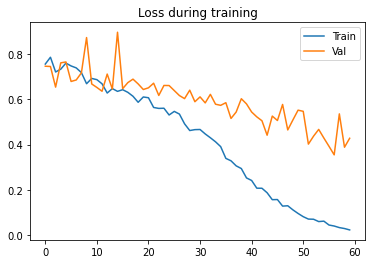

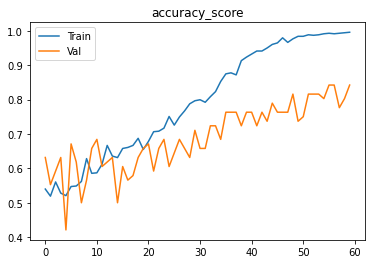

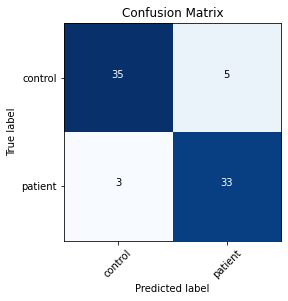

Starting trial 3


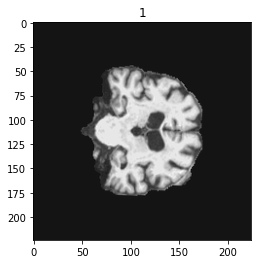

[0,    50] loss: 0.81180
[0,   100] loss: 0.79364
[0,   150] loss: 0.72158
Time elapsed: 0h:0m:35s
train accuracy_score: 51.62 %
val accuracy_score: 51.32 %
Val loss: 0.742181
[1,    50] loss: 0.72084
[1,   100] loss: 0.82107
[1,   150] loss: 0.76933
Time elapsed: 0h:1m:12s
train accuracy_score: 52.65 %
val accuracy_score: 61.84 %
Val loss: 0.717770
[2,    50] loss: 0.77096
[2,   100] loss: 0.71635
[2,   150] loss: 0.76037
Time elapsed: 0h:1m:49s
train accuracy_score: 51.77 %
val accuracy_score: 42.11 %
Val loss: 0.855404
[3,    50] loss: 0.72366
[3,   100] loss: 0.72580
[3,   150] loss: 0.74673
Time elapsed: 0h:2m:25s
train accuracy_score: 55.31 %
val accuracy_score: 65.79 %
Val loss: 0.639070
[4,    50] loss: 0.73466
[4,   100] loss: 0.77945
[4,   150] loss: 0.75001
Time elapsed: 0h:3m:2s
train accuracy_score: 54.13 %
val accuracy_score: 52.63 %
Val loss: 0.682512
[5,    50] loss: 0.70298
[5,   100] loss: 0.71940
[5,   150] loss: 0.72263
Time elapsed: 0h:3m:39s
train accuracy_score: 

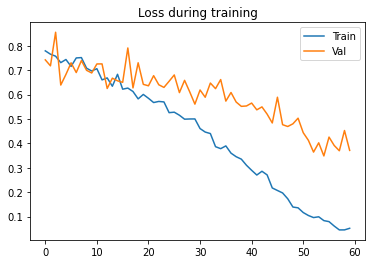

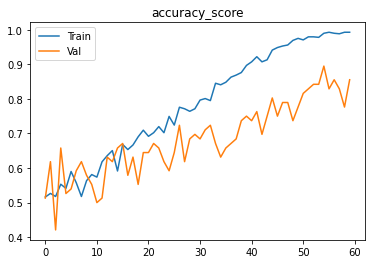

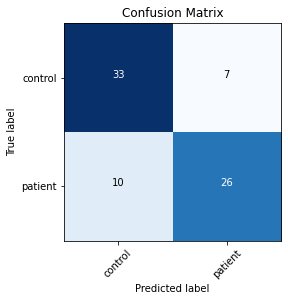

Starting trial 4


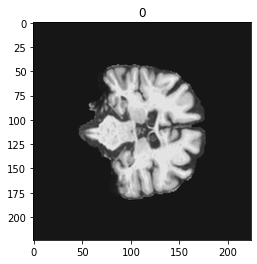

[0,    50] loss: 0.72213
[0,   100] loss: 0.75701
[0,   150] loss: 0.78179
Time elapsed: 0h:0m:35s
train accuracy_score: 48.97 %
val accuracy_score: 60.53 %
Val loss: 0.706722
[1,    50] loss: 0.74885
[1,   100] loss: 0.72310
[1,   150] loss: 0.71603
Time elapsed: 0h:1m:12s
train accuracy_score: 54.57 %
val accuracy_score: 57.89 %
Val loss: 0.664331
[2,    50] loss: 0.76952
[2,   100] loss: 0.72250
[2,   150] loss: 0.75968
Time elapsed: 0h:1m:49s
train accuracy_score: 53.10 %
val accuracy_score: 63.16 %
Val loss: 0.680158
[3,    50] loss: 0.78085
[3,   100] loss: 0.75162
[3,   150] loss: 0.68122
Time elapsed: 0h:2m:25s
train accuracy_score: 55.90 %
val accuracy_score: 60.53 %
Val loss: 0.698415
[4,    50] loss: 0.68015
[4,   100] loss: 0.74876
[4,   150] loss: 0.70512
Time elapsed: 0h:3m:2s
train accuracy_score: 57.96 %
val accuracy_score: 56.58 %
Val loss: 0.734368
[5,    50] loss: 0.72339
[5,   100] loss: 0.79301
[5,   150] loss: 0.74529
Time elapsed: 0h:3m:38s
train accuracy_score: 

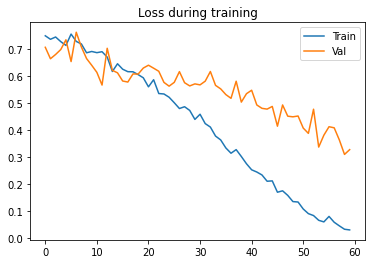

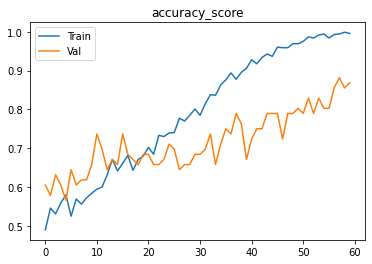

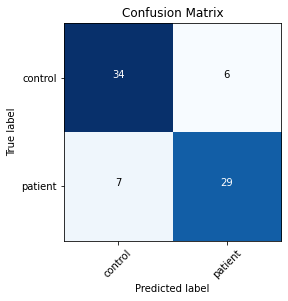

################################
################################
All accuracies: [0.8157894736842105, 0.7368421052631579, 0.8421052631578947, 0.8552631578947368, 0.868421052631579]
0.8236842105263158
0.046779970617450484
4
Starting slice 6
(678, 1, 224, 224)
(76, 1, 224, 224)
/content/drive/MyDrive/ADNI_whole/trained_mcic_cn
Starting trial 0


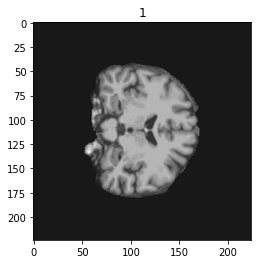

[0,    50] loss: 0.77393
[0,   100] loss: 0.78724
[0,   150] loss: 0.79861
Time elapsed: 0h:0m:36s
train accuracy_score: 47.20 %
val accuracy_score: 44.74 %
Val loss: 0.834086
[1,    50] loss: 0.79036
[1,   100] loss: 0.70914
[1,   150] loss: 0.73318
Time elapsed: 0h:1m:13s
train accuracy_score: 51.77 %
val accuracy_score: 53.95 %
Val loss: 0.695643
[2,    50] loss: 0.82649
[2,   100] loss: 0.78286
[2,   150] loss: 0.77672
Time elapsed: 0h:1m:50s
train accuracy_score: 49.71 %
val accuracy_score: 47.37 %
Val loss: 0.881621
[3,    50] loss: 0.81167
[3,   100] loss: 0.74179
[3,   150] loss: 0.75319
Time elapsed: 0h:2m:27s
train accuracy_score: 52.06 %
val accuracy_score: 56.58 %
Val loss: 0.751367
[4,    50] loss: 0.77086
[4,   100] loss: 0.78596
[4,   150] loss: 0.76594
Time elapsed: 0h:3m:4s
train accuracy_score: 53.39 %
val accuracy_score: 52.63 %
Val loss: 0.692913
[5,    50] loss: 0.74745
[5,   100] loss: 0.76996
[5,   150] loss: 0.75152
Time elapsed: 0h:3m:41s
train accuracy_score: 

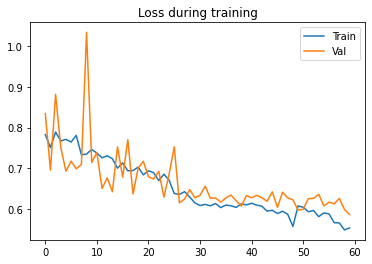

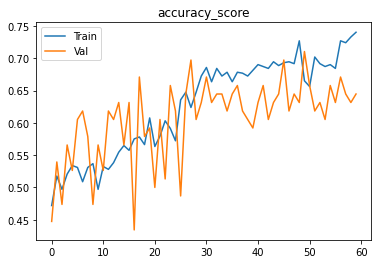

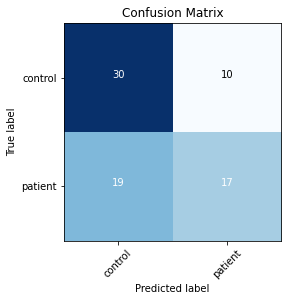

Starting trial 1


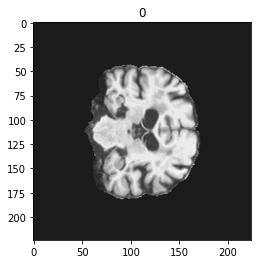

[0,    50] loss: 0.84321
[0,   100] loss: 0.77006
[0,   150] loss: 0.75864
Time elapsed: 0h:0m:35s
train accuracy_score: 47.94 %
val accuracy_score: 44.74 %
Val loss: 0.727466
[1,    50] loss: 0.82115
[1,   100] loss: 0.77147
[1,   150] loss: 0.82061
Time elapsed: 0h:1m:13s
train accuracy_score: 46.31 %
val accuracy_score: 39.47 %
Val loss: 0.789144
[2,    50] loss: 0.77830
[2,   100] loss: 0.78344
[2,   150] loss: 0.82746
Time elapsed: 0h:1m:50s
train accuracy_score: 47.20 %
val accuracy_score: 60.53 %
Val loss: 0.685160
[3,    50] loss: 0.76443
[3,   100] loss: 0.77798
[3,   150] loss: 0.75866
Time elapsed: 0h:2m:27s
train accuracy_score: 51.62 %
val accuracy_score: 36.84 %
Val loss: 0.818480
[4,    50] loss: 0.76000
[4,   100] loss: 0.76580
[4,   150] loss: 0.73388
Time elapsed: 0h:3m:5s
train accuracy_score: 49.41 %
val accuracy_score: 50.00 %
Val loss: 0.800900
[5,    50] loss: 0.71663
[5,   100] loss: 0.72442
[5,   150] loss: 0.78823
Time elapsed: 0h:3m:42s
train accuracy_score: 

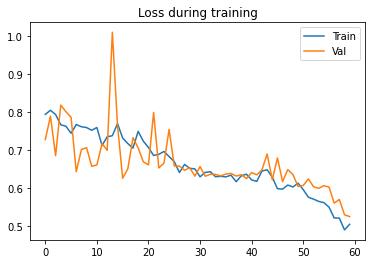

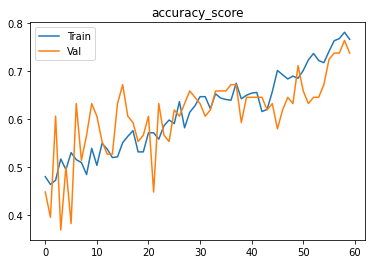

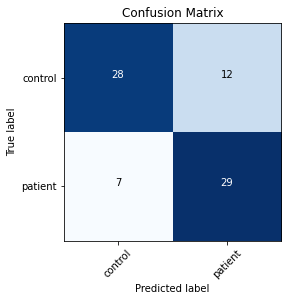

Starting trial 2


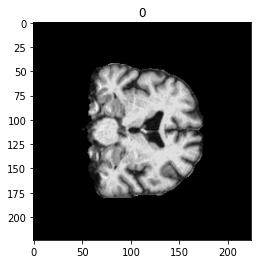

[0,    50] loss: 0.73588
[0,   100] loss: 0.74229
[0,   150] loss: 0.82035
Time elapsed: 0h:0m:35s
train accuracy_score: 52.06 %
val accuracy_score: 47.37 %
Val loss: 0.821926
[1,    50] loss: 0.79608
[1,   100] loss: 0.75480
[1,   150] loss: 0.80224
Time elapsed: 0h:1m:12s
train accuracy_score: 48.53 %
val accuracy_score: 44.74 %
Val loss: 0.770950
[2,    50] loss: 0.79991
[2,   100] loss: 0.73836
[2,   150] loss: 0.67045
Time elapsed: 0h:1m:49s
train accuracy_score: 52.95 %
val accuracy_score: 50.00 %
Val loss: 0.822568
[3,    50] loss: 0.77292
[3,   100] loss: 0.75164
[3,   150] loss: 0.75244
Time elapsed: 0h:2m:26s
train accuracy_score: 51.03 %
val accuracy_score: 59.21 %
Val loss: 0.699030
[4,    50] loss: 0.74461
[4,   100] loss: 0.76000
[4,   150] loss: 0.76151
Time elapsed: 0h:3m:3s
train accuracy_score: 54.28 %
val accuracy_score: 48.68 %
Val loss: 0.766712
[5,    50] loss: 0.74961
[5,   100] loss: 0.74654
[5,   150] loss: 0.77850
Time elapsed: 0h:3m:40s
train accuracy_score: 

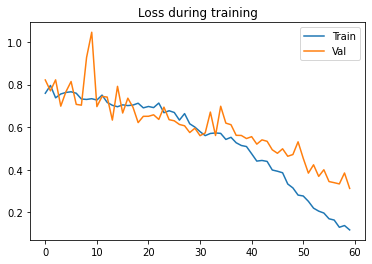

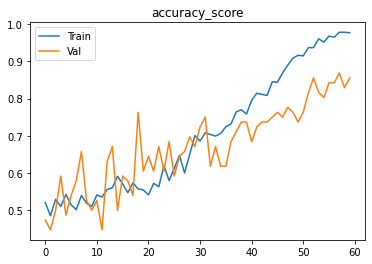

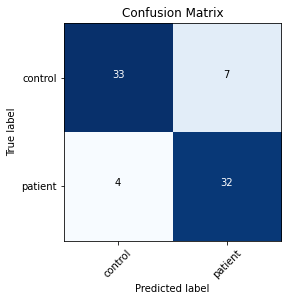

Starting trial 3


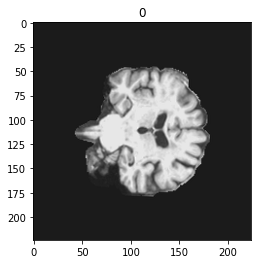

[0,    50] loss: 0.78633
[0,   100] loss: 0.80521
[0,   150] loss: 0.78746
Time elapsed: 0h:0m:35s
train accuracy_score: 50.00 %
val accuracy_score: 50.00 %
Val loss: 0.883463
[1,    50] loss: 0.78912
[1,   100] loss: 0.78065
[1,   150] loss: 0.72816
Time elapsed: 0h:1m:12s
train accuracy_score: 50.88 %
val accuracy_score: 53.95 %
Val loss: 0.720333
[2,    50] loss: 0.75587
[2,   100] loss: 0.78828
[2,   150] loss: 0.78085
Time elapsed: 0h:1m:49s
train accuracy_score: 50.74 %
val accuracy_score: 56.58 %
Val loss: 0.706828
[3,    50] loss: 0.79623
[3,   100] loss: 0.76849
[3,   150] loss: 0.72252
Time elapsed: 0h:2m:26s
train accuracy_score: 51.62 %
val accuracy_score: 43.42 %
Val loss: 0.758790
[4,    50] loss: 0.76587
[4,   100] loss: 0.82283
[4,   150] loss: 0.74579
Time elapsed: 0h:3m:3s
train accuracy_score: 50.15 %
val accuracy_score: 51.32 %
Val loss: 0.774554
[5,    50] loss: 0.75471
[5,   100] loss: 0.74010
[5,   150] loss: 0.78516
Time elapsed: 0h:3m:40s
train accuracy_score: 

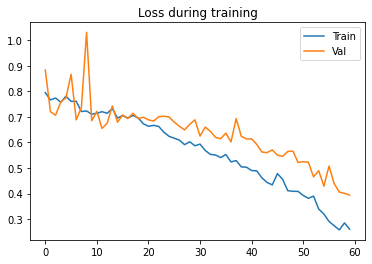

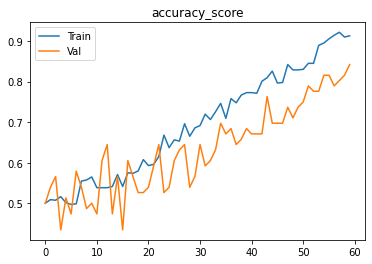

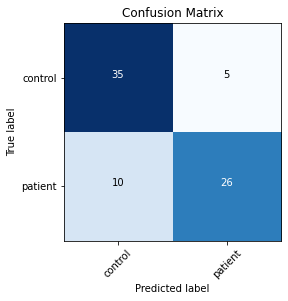

Starting trial 4


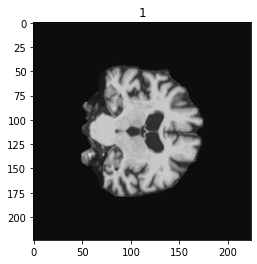

[0,    50] loss: 0.80540
[0,   100] loss: 0.78845
[0,   150] loss: 0.71224
Time elapsed: 0h:0m:36s
train accuracy_score: 51.62 %
val accuracy_score: 48.68 %
Val loss: 0.728166
[1,    50] loss: 0.78307
[1,   100] loss: 0.71721
[1,   150] loss: 0.79456
Time elapsed: 0h:1m:13s
train accuracy_score: 53.83 %
val accuracy_score: 48.68 %
Val loss: 0.724513
[2,    50] loss: 0.76034
[2,   100] loss: 0.80251
[2,   150] loss: 0.78823
Time elapsed: 0h:1m:50s
train accuracy_score: 50.59 %
val accuracy_score: 55.26 %
Val loss: 0.964497
[3,    50] loss: 0.78762
[3,   100] loss: 0.70609
[3,   150] loss: 0.82617
Time elapsed: 0h:2m:28s
train accuracy_score: 47.79 %
val accuracy_score: 48.68 %
Val loss: 0.992218
[4,    50] loss: 0.76277
[4,   100] loss: 0.73614
[4,   150] loss: 0.76883
Time elapsed: 0h:3m:4s
train accuracy_score: 53.98 %
val accuracy_score: 43.42 %
Val loss: 0.795119
[5,    50] loss: 0.80874
[5,   100] loss: 0.74197
[5,   150] loss: 0.75778
Time elapsed: 0h:3m:42s
train accuracy_score: 

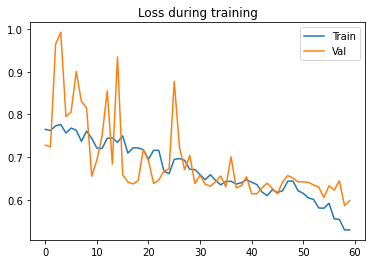

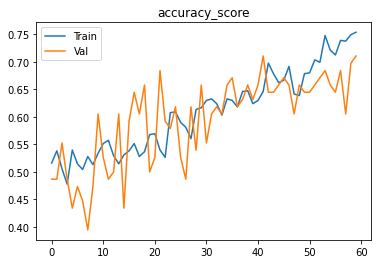

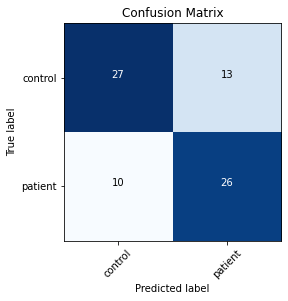

################################
################################
All accuracies: [0.6447368421052632, 0.7368421052631579, 0.8552631578947368, 0.8421052631578947, 0.7105263157894737]
0.7578947368421053
0.0800796002879102
2


In [ ]:
for z_slice in range(0, 7):
    print('Starting slice {}'.format(z_slice))

    x_train_z = crop(x_train, z_slice=z_slice, dims=(224, 224))
    x_train_z = min_max(x_train_z)
    x_val_z = crop(x_val, z_slice=z_slice, dims=(224, 224))
    x_val_z = min_max(x_val_z)

    print(x_train_z.shape)
    print(x_val_z.shape)
    #print(y_train.shape)
    #print(y_val.shape)
    #print(sum(y_train))
    #print(sum(y_val))

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    class ADNIDataset(Dataset):
        def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=torch.float32, num_classes=2):
            self.X = np.copy(X)
            self.y = np.copy(y)
            self.X = X
            self.y = y
            self.transform = transform
            self.target_transform = target_transform
            self.mask = mask
            self.z_factor = z_factor
            self.dtype = dtype
            self.num_classes = num_classes

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            image = self.X[idx]
            label_tensor = np.zeros(shape=(self.num_classes,))
            label = self.y[idx] >= 0.5
            label = torch.LongTensor([label])

            if self.transform:
                image = self.transform(image)

            sample = {"image" : image,
                     "label" : label}
            return sample

    augmentations = [SagittalRotate()]
    adni_data_train = ADNIDataset(x_train_z[:,0,:,:], y_train, transform = transforms.Compose(augmentations + [ToTensor()]),
                                  dtype=torch.float32)
    adni_data_val = ADNIDataset(x_val_z[:,0,:,:], y_val, transform = transforms.Compose(augmentations + [ToTensor()]),
                                  dtype=torch.float32)


    net = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, resolution=(224, 224), heads=8).cuda(gpu)

    #net = VisionTransformer(img_size=224, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12).to('cuda')

    #net = ResNet_with_BotStack(fmap_size=[224, 224], botnet=True, num_classes=2).cuda(gpu)

    def run(
        net,
        data,
        shape,
        callbacks=[],
        augmentations=[],
        masked=False,
        metrics=[],
        k_folds=None,
        b=4,
        num_epochs=60,
        retain_metric=None):

        fold_metric = []
        models = []
        fold = 0
        initial_prepend = None

        # set number of cross-validation folds
        for trial in range(5):
            print("Starting trial {}".format(trial))

            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
            fold += 1

            # restart model
            del net
            net = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, resolution=(224, 224), heads=8).cuda(gpu)

            #net = VisionTransformer(img_size=224, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12).to('cuda')

            #net = ResNet_with_BotStack(fmap_size=[224, 224], botnet=True, num_classes=2).cuda(gpu)

            # reset hyperparameters
            lr = 3e-5
            wd = 8e-5
            criterion = nn.CrossEntropyLoss().cuda(gpu)
            base_optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)  # define an optimizer for the "sharpness-aware" update
            optimizer = SAM(net.parameters(), base_optimizer)

            train_loader = DataLoader(adni_data_train, batch_size=b, num_workers=0, shuffle=True)
            val_loader = DataLoader(adni_data_val, batch_size=1, num_workers=0, shuffle=True)


            # plot slice (optional)
            sample = next(iter(train_loader))
            img = sample["image"][0]
            lbl = sample["label"][0]
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(lbl.item())
            plt.show()
            model_trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="classification")

            # train model and store results
            net, report = model_trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=50,
                show_validation_epochs=1)
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                fold_metric.append(report["val_metrics"][retain_metric][-1])
            else:
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

            models.append(net)
            print("Finished fold.")

            # visualize result (optional)
            model_trainer.visualize_training(report, metrics)
            model_trainer.evaluate_model(val_loader)

        print("################################")
        print("################################")
        print("All accuracies: {}".format(fold_metric))
        return fold_metric, models

    net = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, resolution=(224, 224), heads=8).cuda(gpu)
    #net = VisionTransformer(img_size=224, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12).to('cuda')
    #net = ResNet_with_BotStack(fmap_size=[224, 224], botnet=True, num_classes=2).cuda(gpu)
    num_epochs = 60
    min_iters = 3
    ignore_epochs = 15
    normalize = False
    retain_metric = accuracy_score
    metrics = [accuracy_score]
    model_path = '/content/drive/MyDrive/ADNI_whole/trained_mcic_cn'
    r = 0

    check = ModelCheckpoint(path=model_path,
                        prepend="repeat_{}".format(r),
                        store_best=True,
                        ignore_before=ignore_epochs,
                        retain_metric=retain_metric)

    callbacks = [check, EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

    fold_metric, models = run(net=net, data=adni_data_train,
                          k_folds=-1,
                          callbacks=None,
                          shape=-1,
                          masked=False,
                          metrics=metrics,
                          b=4,
                          num_epochs=num_epochs,
                          retain_metric=retain_metric
                          )

    print(np.mean(fold_metric))
    print(np.std(fold_metric))
    best = np.array(fold_metric).argmax()
    print(best)
    torch.save(models[best].state_dict(), model_path + '/' + '2D_Slice_' + str(z_slice))


## Inference

In [ ]:
img_dir = ('/content/drive/MyDrive/ADNI_whole/CNvsMCIc/test/') # change this to directory with MRI images
img_files = sorted(os.listdir(img_dir))


# read in CSV description of downloaded MRI scans
df = pd.read_csv('/content/drive/MyDrive/ADNI_whole/CNvsMCIc/MCIc_CN_2.csv')

# create x and y arrays
group = []
for i in range(len(img_files)):
    idx = img_files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0])
group = ((np.array(group) == 'MCIc') / 1)
ims = np.array([nib.load(img_dir + file).get_fdata()[:,:,30:70:4] for file in img_files])

tmp = np.arange(len(img_files))
#train, val = train_test_split(tmp, test_size=.1, shuffle = True, stratify = group, random_state = 12)
x_test = []
for file in np.array(img_files)[tmp]:
    x_test.append(np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:]]))
x_test = np.array(x_test)[:,0,:,:,:,:]
y_test = group[tmp]
#x_val = np.array([nib.load(img_dir + file).get_fdata()[:,72:152:8,:,:] for file in np.array(img_files)[val]])
#y_val = group[val]

print(x_test.shape)
#print(x_val.shape)
print(y_test.shape)
#print(y_val.shape)
print(sum(y_test))
#print(sum(y_val))

(26, 256, 10, 256, 1)
(26,)
9.0


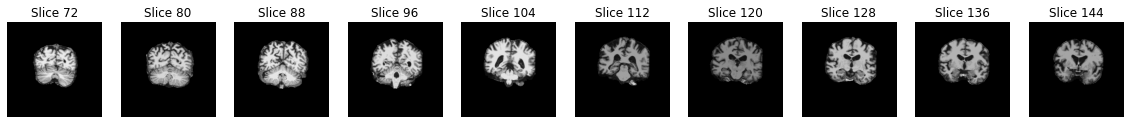

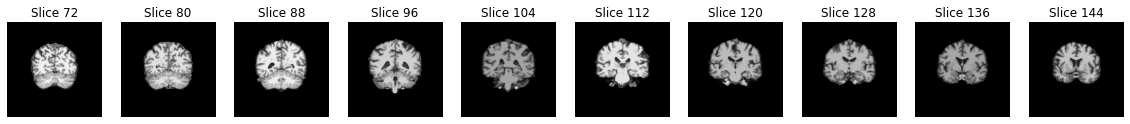

In [ ]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, i, :].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(72 + 8 * i))

show_slices(x_test[0,:,:,:,0])
show_slices(x_test[15,:,:,:,0])

In [ ]:
class ADNIDataset(Dataset):
  def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=torch.float32, num_classes=2):
    self.X = np.copy(X)
    self.y = np.copy(y)
    self.X = X
    self.y = y
    self.transform = transform
    self.target_transform = target_transform
    self.mask = mask
    self.z_factor = z_factor
    self.dtype = dtype
    self.num_classes = num_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    image = self.X[idx]
    label_tensor = np.zeros(shape=(self.num_classes,))
    label = self.y[idx] >= 0.5
    label = torch.LongTensor([label])

    if self.transform:
      image = self.transform(image)

    sample = {"image" : image,
              "label" : label}
    return sample

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [ ]:
from sklearn.metrics import roc_curve

Starting slice 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.7686802744865417, 0.1436687558889389, 0.10293611139059067, 0.9607105255126953, 0.039262060075998306, 0.9978184700012207, 0.0652722716331482, 0.9794623255729675, 0.07794910669326782, 0.3442020118236542, 0.9195619225502014, 0.31763285398483276, 0.2266717106103897, 0.13645149767398834, 0.998422384262085, 0.30419349670410156, 0.3516347408294678, 0.9993734955787659, 0.04226712882518768, 0.21147632598876953, 0.43288975954055786, 0.34079378843307495, 0.9996289014816284, 0.2096574306488037, 0.6860893368721008, 0.02381991036236286]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.21740330755710602, 0.10520073026418686, 0.07895047217607498, 0.6558555960655212, 0.35743778944015503, 0.9863496422767639, 0.2522873282432556, 0.964624285697937, 0.2610519826412201, 0.2177082598209381, 0.2533530592918396, 0.3243063986301422, 0.06386270374059677, 0.10582638531923294, 0.9804462790489197, 0.12890127301216125, 0.27750515937805176, 0.9962112903594971, 0.047842349857091904,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.6596989631652832, 0.1729719191789627, 0.37912067770957947, 0.7832010388374329, 0.20258364081382751, 0.9932126998901367, 0.15868541598320007, 0.7229256629943848, 0.12675003707408905, 0.12453239411115646, 0.99395352602005, 0.36141127347946167, 0.8265298008918762, 0.22343675792217255, 0.9580209851264954, 0.21891215443611145, 0.41746482253074646, 0.8513427376747131, 0.07973244041204453, 0.025199435651302338, 0.3713044226169586, 0.5605744123458862, 0.9996820688247681, 0.32248467206954956, 0.8418338298797607, 0.9381961822509766]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.46674224734306335, 0.0746551975607872, 0.09395140409469604, 0.8910289406776428, 0.03486187383532524, 0.9996719360351562, 0.15917184948921204, 0.994014322757721, 0.1788255125284195, 0.0953444242477417, 0.5815812945365906, 0.2644299268722534, 0.06597897410392761, 0.31978607177734375, 0.9963400363922119, 0.12599614262580872, 0.2522786855697632, 0.9986752867698669, 0.13003748655319214, 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.25890788435935974, 0.0592033714056015, 0.4827525317668915, 0.7006475329399109, 0.13079026341438293, 0.9718709588050842, 0.06394578516483307, 0.017711736261844635, 0.17409706115722656, 0.3402961194515228, 0.987544059753418, 0.3425839841365814, 0.9708022475242615, 0.3021407127380371, 0.9553050398826599, 0.7450222373008728, 0.2588576674461365, 0.9894635677337646, 0.3165271282196045, 0.03638151288032532, 0.20007531344890594, 0.7859325408935547, 0.8937346935272217, 0.0872897282242775, 0.9967317581176758, 0.9744176864624023]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.7124788165092468, 0.04043334349989891, 0.046969860792160034, 0.34564879536628723, 0.259275883436203, 0.8567924499511719, 0.19695189595222473, 0.4334990680217743, 0.3326988220214844, 0.02114425227046013, 0.797981858253479, 0.36075466871261597, 0.021610472351312637, 0.07457272708415985, 0.9546391367912292, 0.030298324301838875, 0.26621904969215393, 0.9981856942176819, 0.04378427937626839, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.24853329360485077, 0.18167300522327423, 0.16357016563415527, 0.22877974808216095, 0.3013988137245178, 0.9965026378631592, 0.61616051197052, 0.14701417088508606, 0.33738216757774353, 0.32807740569114685, 0.9140139222145081, 0.08470961451530457, 0.1532077193260193, 0.1933465600013733, 0.854466438293457, 0.4221160113811493, 0.48301345109939575, 0.9807618260383606, 0.4702920615673065, 0.0881352573633194, 0.061323199421167374, 0.41353529691696167, 0.9790782332420349, 0.8553283214569092, 0.8548227548599243, 0.8316432237625122]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.10242792218923569, 0.0445106141269207, 0.1925557553768158, 0.0930895209312439, 0.3413238227367401, 0.9141066074371338, 0.05566554516553879, 0.1848011314868927, 0.2314109355211258, 0.028560560196638107, 0.8555187582969666, 0.2007344663143158, 0.06593001633882523, 0.2004547417163849, 0.4021226167678833, 0.12356444448232651, 0.3470984399318695, 0.9753560423851013, 0.03581215441226959, 0.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.9530091881752014, 0.32710808515548706, 0.12255362421274185, 0.3572808802127838, 0.8348959684371948, 0.9878597855567932, 0.43729597330093384, 0.4007580280303955, 0.23978367447853088, 0.39977768063545227, 0.0903010219335556, 0.07967684417963028, 0.20241446793079376, 0.09048379212617874, 0.3835706412792206, 0.3521810472011566, 0.21257919073104858, 0.8624768853187561, 0.05655848979949951, 0.18299205601215363, 0.4293004274368286, 0.1741902381181717, 0.9795241951942444, 0.3020475208759308, 0.4600565731525421, 0.37578877806663513]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.7108410000801086, 0.16767960786819458, 0.39551302790641785, 0.2358843982219696, 0.3917485177516937, 0.32750609517097473, 0.19671455025672913, 0.17498354613780975, 0.21704812347888947, 0.19408869743347168, 0.265103280544281, 0.10704198479652405, 0.18309780955314636, 0.13207577168941498, 0.6658878922462463, 0.28353312611579895, 0.4054500460624695, 0.926600992679596, 0.0067849489860236

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.5200741291046143, 0.2521340847015381, 0.31076985597610474, 0.11868921667337418, 0.271994948387146, 0.9513212442398071, 0.3648931682109833, 0.8185675144195557, 0.16546288132667542, 0.16053660213947296, 0.3518245816230774, 0.3540380895137787, 0.15820933878421783, 0.24121631681919098, 0.32369792461395264, 0.5891109108924866, 0.12095049023628235, 0.8597337603569031, 0.8904521465301514, 0.1179310753941536, 0.1485873907804489, 0.10480232536792755, 0.6349298357963562, 0.2248069941997528, 0.34672412276268005, 0.2547137439250946]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.2863805890083313, 0.2120361477136612, 0.2648092210292816, 0.26646536588668823, 0.17883378267288208, 0.25219470262527466, 0.36723700165748596, 0.24943546950817108, 0.18635717034339905, 0.08009770512580872, 0.4111270308494568, 0.29371410608291626, 0.11963547021150589, 0.24953368306159973, 0.4395963251590729, 0.08534278720617294, 0.23484328389167786, 0.7803154587745667, 0.0233213845640420

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


[0.2229069322347641, 0.2734863758087158, 0.33730828762054443, 0.724796712398529, 0.130077064037323, 0.523010790348053, 0.08975836634635925, 0.3373304009437561, 0.2902086079120636, 0.2600981891155243, 0.29141315817832947, 0.29155629873275757, 0.2799663543701172, 0.8067673444747925, 0.36329856514930725, 0.17363758385181427, 0.23735466599464417, 0.9250895977020264, 0.041788022965192795, 0.11856038868427277, 0.2993994653224945, 0.22634699940681458, 0.7864161729812622, 0.20937785506248474, 0.9503244757652283, 0.22506588697433472]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0]
[0.21374952793121338, 0.3243826925754547, 0.15650394558906555, 0.5315020084381104, 0.12909679114818573, 0.8389154076576233, 0.22213275730609894, 0.20717008411884308, 0.191829115152359, 0.23122523725032806, 0.3406785726547241, 0.17890647053718567, 0.13546346127986908, 0.21394161880016327, 0.509151816368103, 0.11113061755895615, 0.21700064837932587, 0.8847374320030212, 0.05421219766139984,

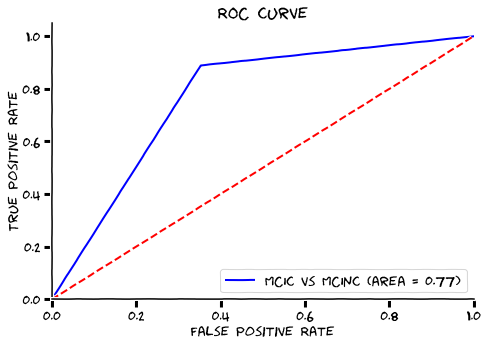

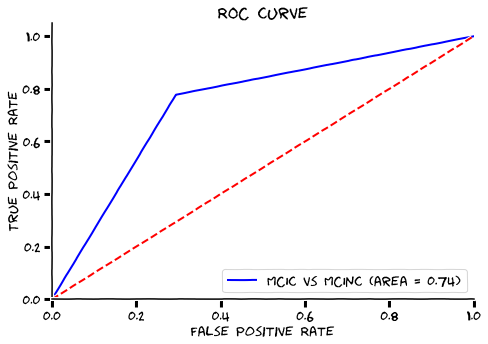

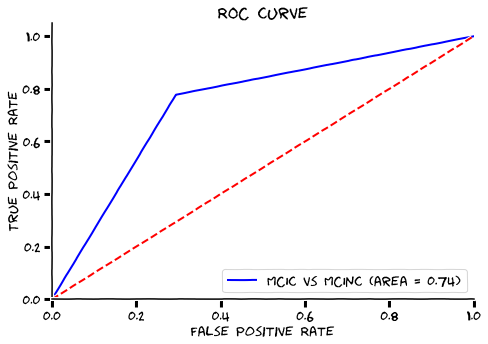

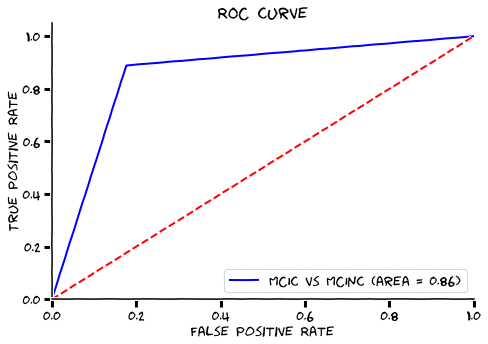

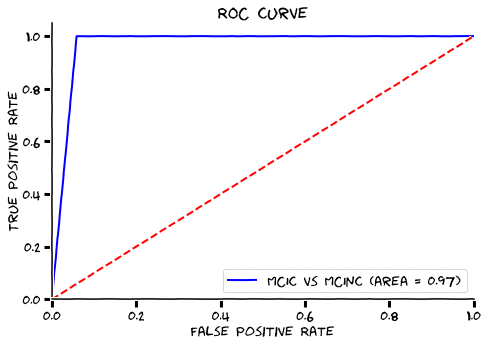

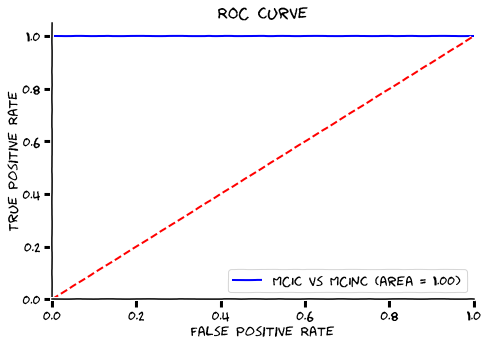

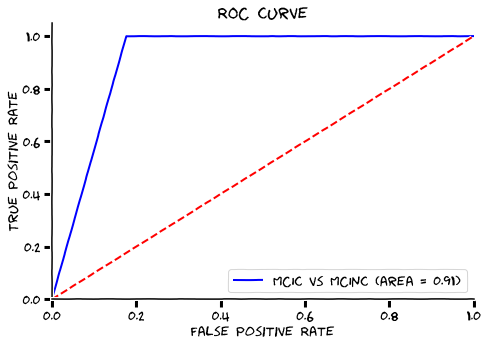

In [ ]:
#y_hat = []
model_path = '/content/drive/MyDrive/ADNI_whole/trained_mcic_cn'

for z_slice in range(0, 7):
  print('Starting slice {}'.format(z_slice))
  y_hat = []
  x_test_z = crop(x_test, z_slice=z_slice, dims=(224, 224))
  x_test_z = min_max(x_test_z)

  with torch.no_grad():
    for _ in range(len(os.listdir(model_path))):
      if type(ims) != torch.Tensor:
        ims = torch.from_numpy(ims).float()
      #x_test = torch.moveaxis(ims[:,:,:,_], -1, 1)
     # for i in range(len(x_test)):
      #  x_test[i] -= torch.min(x_test[i])
       # x_test[i] /= torch.max(x_test[i])
      #test_loader = DataLoader(ADNIDataset(x_test, group), batch_size=1, num_workers=0, shuffle=False)
      augmentations = [SagittalRotate()]
      adni_data_test = ADNIDataset(x_test_z[:,0,:,:], y_test, transform = transforms.Compose(augmentations + [ToTensor()]),
                                  dtype=torch.float32)
      test_loader = DataLoader(adni_data_test, batch_size=1, num_workers=0, shuffle=False)
      all_preds = []
      all_labels = []
      model = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=2, resolution=(224, 224), heads=8).cuda(gpu)
      model.load_state_dict(torch.load(model_path + '/' + os.listdir(model_path)[_]))
      model.eval()
      for sample in test_loader:
        img = sample["image"]
        label = sample["label"]
        img = img.to(torch.device(gpu))
        output = model.forward(img)
        #pred = torch.argmax(F.softmax(output, dim=1))
        pred = F.softmax(output, dim=1)[0][1]
        all_preds.append(pred.cpu().numpy().item())
        all_labels.append(label.numpy().item())
      print(all_preds)
      print(all_labels)
      #print(classification_report(all_labels, all_preds))
      y_hat.append(all_preds)
      del model
  #y_test = group.astype(int)
  y_hat = ((np.mean(y_hat, axis = 0) >= .4)/1).astype(int)
  print(y_test)
  print(y_hat)

  #roc_score = []
  print(classification_report(y_test, y_hat))
  print(f'ROC_AUC score is {roc_auc_score(y_test, y_hat)}')
  roc_score = roc_auc_score(y_test, y_hat)

  plt.xkcd(randomness=0,scale=0.1)

  fig, ax = plt.subplots(figsize = (7,5))
  fig.patch.set_facecolor('None')
  fig.patch.set_alpha(0)
  plot_roc(y_test,y_hat,ax)
  [ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
  ax.patch.set_facecolor('None')
  ax.patch.set_alpha(0)
  plt.tight_layout()

In [ ]:
def plot_roc(test,logprobs,axis):
    fpr, tpr, thresholds = roc_curve(test, logprobs)
    ax.plot(fpr, tpr, label=f'MCIc vs MCInc (area = {roc_score:.2f})', color = 'b')
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.4,
    )
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    ax.legend(loc="lower right")

In [ ]:
plt.xkcd(randomness=0,scale=0.1)
y_probs = lreg_new.predict_proba(x_AA_new)[:,1]
fig, ax = plt.subplots(figsize = (7,5))
fig.patch.set_facecolor('None')
fig.patch.set_alpha(0)
plot_roc(y_AA,y_probs,ax)
[ax.spines[key].set_visible(False) for key in ax.spines.keys() if key not in ['bottom','left']];
ax.patch.set_facecolor('None')
ax.patch.set_alpha(0)
plt.tight_layout()